<a href="https://colab.research.google.com/github/tahaShm/ai-simple-nn/blob/master/AI_CA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>AI CA5<center><h1>

<h2><center>Image classification with multi-layer neural networks<center><h1>


Taha Shabani

810196491

---







#Prelude

---

##Definition of project : 
The goal of this project is to implement a multi-layar neural network (we will call it "nn") using pytorch, in order to train on an image dataset and to test and to work with different features of it during training to gain more accuracy and better results.

**Main issues are** : cost function, optimization (SDG: stochastic gradient desent), batch size, epochs, learning rate, activation function, weight initialization, regularization)

---

##Primitive functions and classes : 


```
ToTensor() 
```
**ToTensor1()** and **ToTensor255()** are used as transformers. **ToTensor1** just transforms images into numpy arrays, but **ToTensor255** normalize values with a division of 256 -> (rgb values are between 0 to 255)


```
getDistribution(loader, classes) 
```
We use this function to count images per classes

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler


import time
from datetime import timedelta
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class ToTensor1(object):
    """Convert PIL Images in sample to pytorch Tensors."""

    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

class ToTensor255(object):
    """Convert PIL Images in sample to pytorch Tensors."""

    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)

In [ ]:
def readDataSet(data_path) : 
    trainDataset = ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    trainLoader = torch.utils.data.DataLoader(
        trainDataset,
        batch_size=64,
        num_workers=16,
        shuffle=True
    )
    classes = trainDataset.classes
    return [trainLoader, classes]

In [ ]:
def showProgressPercentage(current, total) : 
    prevPercentage = int ((current-1) / total * 100)
    currPrecentage = int (current / total * 100)
    progress = 0
    if (currPrecentage >= 90 and prevPercentage < 90) : 
        progress = 90
    elif (currPrecentage >= 80 and prevPercentage < 80) : 
        progress = 80 
    elif (currPrecentage >= 70 and prevPercentage < 70) : 
        progress = 70 
    elif (currPrecentage >= 60 and prevPercentage < 60) : 
        progress = 60 
    elif (currPrecentage >= 50 and prevPercentage < 50) : 
        progress = 50 
    elif (currPrecentage >= 40 and prevPercentage < 40) : 
        progress = 40 
    elif (currPrecentage >= 30 and prevPercentage < 30) : 
        progress = 30 
    elif (currPrecentage >= 20 and prevPercentage < 20) : 
        progress = 20 
    elif (currPrecentage >= 10 and prevPercentage < 10) : 
        progress = 10 
    if (progress > 0) :
        print(progress, "%")
        

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache
print(t)
print(c)
print(a)
print(f)
print(device)

17071734784
0
0
0
cuda:0


In [ ]:
def getDistribution(loader, classes):
    total_category_count = {classes[i] : 0 for i in range(len(classes))}
    i = 0
    total = len(loader)
    for _, labels in loader:
        i += 1
        showProgressPercentage(i, total)
        for label in labels:
            total_category_count[ classes[label] ] += 1
    for category in classes:
        print('%s : %d' % (category, total_category_count[category]))
    return total_category_count


In [ ]:
!unzip -n "/content/gdrive/My Drive/categorized_products.zip"

dataset = readDataSet("categorized_products")
datasetLoader = dataset[0]
datasetClasses = dataset[1]
categoryCounts = getDistribution(datasetLoader, datasetClasses)

Archive:  /content/gdrive/My Drive/categorized_products.zip
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Accessory Gift Set : 111
Backpacks : 722
Belts : 813
Capris : 175
Caps : 283
Casual Shoes : 2846
Clutches : 290
Cufflinks : 106
Deodorant : 347
Dresses : 464
Dupatta : 116
Earrings : 417
Flats : 500
Flip Flops : 916
Formal Shoes : 637
Handbags : 1757
Heels : 1323
Innerwear Vests : 241
Jackets : 258
Jeans : 608
Kajal and Eyeliner : 102
Kurtas : 1844
Kurtis : 234
Leggings : 177
Lip Gloss : 144
Lipstick : 315
Nail Polish : 329
Necklace and Chains : 160
Night suits : 141
Nightdress : 189
Pendant : 175
Perfume and Body Mist : 613
Ring : 118
Sandals : 897
Sarees : 424
Scarves : 117
Shirts : 3213
Shorts : 547
Skirts : 128
Socks : 686
Sports Shoes : 2035
Sunglasses : 1073
Sweaters : 277
Sweatshirts : 285
Ties : 261
Tops : 1762
Track Pants : 303
Trousers : 530
Tshirts : 3534
Tunics : 229
Wallets : 936
Watches : 2541


---
#Part 1

---

##Showing 12 categories:
After creating dataset loaders, its time to show 12 categories, first we read a batch of current dataset loader with <mark>data_iter.next()</mark> and then pass it to <mark>show12Categories()</mark>. Inside this function we show a 3*4 plot which contains 12 different category images.

**Note** : transpose to (1,2,0) is because for the first part we used <mark>pytorch.ToTonsor()</mark> function which transform [a,b,c] to [b,c,a].





<Figure size 1080x576 with 0 Axes>

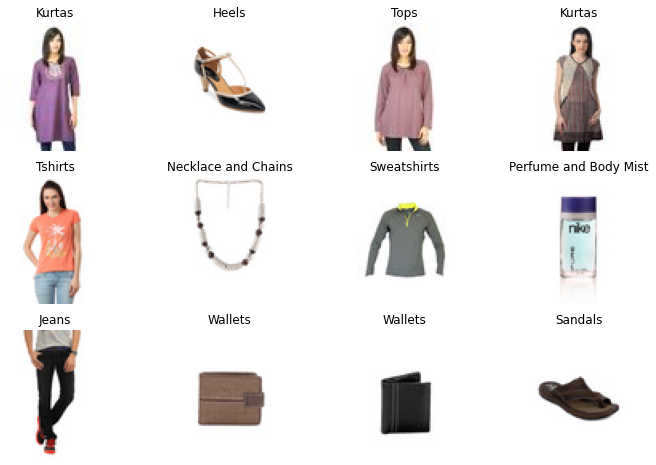

In [ ]:
def show12Categoriese(img_array, labels, classes):
    plt.figure(figsize=(15, 8))
    _, pic = plt.subplots(3, 4, figsize=(12,8))
    for i in range(3):
        for j in range(4):
            pic[i][j].imshow(np.transpose(img_array[i * 4 + j].numpy(), (1, 2, 0)))
            pic[i][j].set_title(classes[labels[i * 4 + j]])
            pic[i][j].axis('off')
    plt.show()

data_iter = iter(datasetLoader)
data_iter.next()
images, labels = data_iter.next()

show12Categoriese(images[0:12], labels[0:12], datasetClasses)

---
#Part 2

---

##2A: Categories Bar graph  : 


```
showCategories()
```
First, we sort categories based on their items (for desending order : **reverse = true**) then we plot them using matplotlib.

---

<class 'dict'>


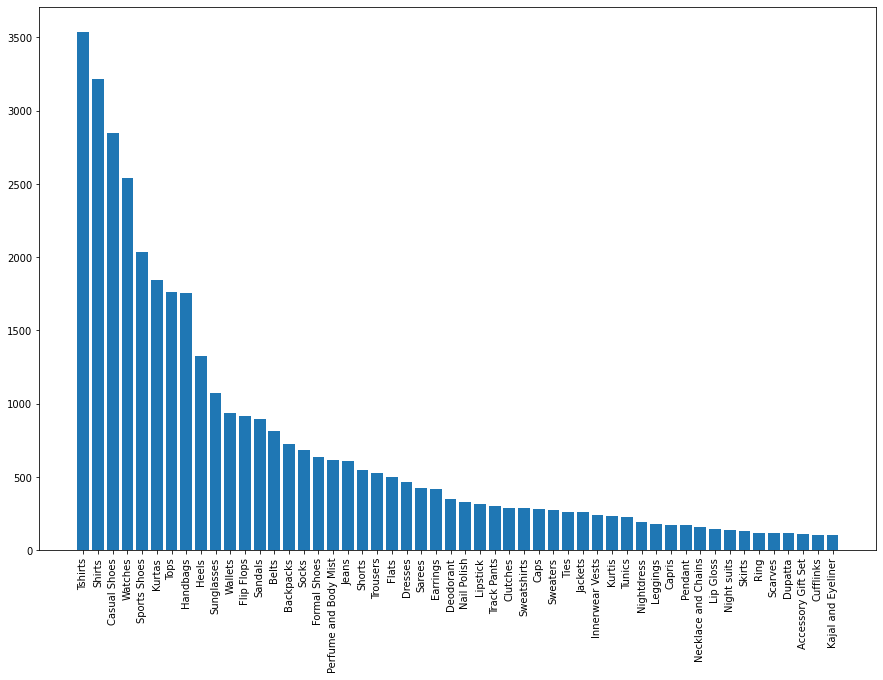

In [ ]:
print(type(categoryCounts))
sortedCategories = {k: v for k, v in sorted(categoryCounts.items(), key=lambda item: item[1], reverse=True)}
def showCategories(categories) :
    keys = categories.keys()
    values = categories.values()
    plt.figure(figsize=(15, 10))
    plt.xticks(rotation=90)
    plt.bar(keys, values)
    plt.show()
showCategories(sortedCategories)

---
##2B: 


```
split_train_test(data_path, ratio, tensorType = 1)
```
**split_train_test()** is used to split dataset into train and test sets. (80% train, 20% test). This function has an input variable named <mark>tensorType</mark> which clarifies type of transforming : **ToTensor1()** and **ToTensor255()** (explained in **Prelude**).

First, we transform dataloader **x** to grayscale and one of ToTensor functions, then we shuffle the indexes and add first 80% of data into **train data** and the rest into **test data**. We will use this function in later parts.

---

In [ ]:
from random import sample

def split_train_test(data_path, ratio, tensorType = 1) : 
    if (tensorType == 1) : 
        x = ImageFolder(
            root=data_path,
            transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    ToTensor1()])
        )
    else: 
        x = ImageFolder(
            root=data_path,
            transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    ToTensor255()])
        )
    
    classes = categoryCounts
    classesCounter = {datasetClasses[i] : 0 for i in range(len(datasetClasses))}
    
    train = []
    test = []
    idxList = list(range(len(x)))
    idxList = sample(idxList, len(x))
    
    for i in idxList:
        curClass = datasetClasses[x[i][1]]
        if (classesCounter[curClass] <= int((1-ratio) * classes[curClass])) :
            train.append(x[i])
        else :
            test.append(x[i])
        classesCounter[curClass] += 1
        
    return [train, test]
print("done")

done


---
#Part 3

---

##3 Prerequisites: 
These functions and classes are used from part 3 to part 11 : 


```
Model
```
This class is to implement layers and their norons, and <mark>forward()</mark> is to implement reshaping of **x** to a tensor with x.size columns and appropriate rows per columns (denoted with -1) and then to forward values via **x**.

```
makeRequisites(tensorType, classes, activationFunction, learningRate, batchSize, epochs, workers, curMomentum = 0, weightDecay = 0)
```
This function play an important role in whole project:


1.   splits train and test data using <mark>split_train_test()</mark> (explanined in part 2).
2.   moves model to GPU
3.   defines primitives: ->  **defaults**(**activation function**: relu, **learning rate**: 0.01, **batch size**: 64, **epochs**: 10, **workers**: 16, **criterion**: cross entropy, **optimization algorithm**: SGD[stochastic gradiant decent], **initial weights**: random )

```
fit()
```
In order to train model over train data we use fit(). Per every epoch and inside that per every batch we read from loader, first, we clear gradiants to train parameters and back propagate currectly for current batch bacause **PyTorch accumulates the gradients by default**, then we store outputs, and based on output, evaluate loss, and based on loss, back propagate to minimize it.

Finally we store average losses per every epoch and return them for future needs.

```
showPartDetails()
```
This Function uses three main sub-functions:


1.   <mark>showAccuracy()</mark> : this function calculate total accuracy (number of total predictions / number of predictions). We show the results using pandas dataframe.
2.   <mark>showPerClassAccuracy()</mark> : **this function calculate recall per every class (tp / tp + fn)** -> (**tp**: true positive, means those which predicted correct for current class, **fn**: false negative, means those which are labeled for current class, but, are predicted wrong to another class.) We show the results using **matplotlib**.
3.   <mark>showLossDiff()</mark> : shows average losses which were gained from **fit()** . We show the results using **matplotlib**.


---

In [ ]:
class Model(nn.Module):
    def __init__(self, numOfClasses, actFunction=F.relu):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 16 * 40 * 30)
        self.act1 = actFunction

        self.layer2 = nn.Linear(16 * 40 * 30, 48 * 12 * 10)
        self.act2 = actFunction

        self.layer3 = nn.Linear(48 * 12 * 10, 96 * 4 * 5)
        self.act3 = actFunction

        self.layer4 = nn.Linear(96 * 4 * 5, 256)
        self.act4 = actFunction

        self.layer5 = nn.Linear(256, numOfClasses)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [ ]:
def printGpuInfo() : 
  t = torch.cuda.get_device_properties(0).total_memory
  c = torch.cuda.memory_cached(0)
  a = torch.cuda.memory_allocated(0)
  f = c-a  # free inside cache
  print(t)
  print(c)
  print(a)
  print(f)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# printGpuInfo()


cuda:0


In [ ]:
def makeRequisites(tensorType, classes, activationFunction, learningRate, batchSize, epochs, workers, curMomentum = 0, weightDecay = 0) : 

  [train, test] = split_train_test("categorized_products", 0.2, tensorType)

  model = Model(len(classes), activationFunction)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  if (curMomentum == 0) : 
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay)
  else :
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=curMomentum, weight_decay=weightDecay)
  trainLoader = torch.utils.data.DataLoader(
      train,
      batch_size=batchSize,
      num_workers=workers,
      shuffle=True
  )
  testLoader = torch.utils.data.DataLoader(
      test,
      batch_size=batchSize,
      num_workers=workers,
      shuffle=False
  )
  return [activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader]

In [ ]:
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(1, datasetClasses, F.relu, 0.01, 64, 10, 16)


In [ ]:
def fit(model, trainLoader, device, criterion, optimizer, epochs):

    total_time = 0.
    avgLosses = []
    for epoch in range(epochs):
        trainLoss = 0.
        d1 = datetime.now()
        for images, labels in trainLoader:
          
            images = images.to(device)
            labels = labels.to(device)
          
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            trainLoss += loss.item()

        average_loss = trainLoss / len(trainLoader)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        avgLosses.append(average_loss)
        print('epoch %d, trainLoss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
    print('total training time: %.3f minutes' % (total_time / 60))
    return avgLosses

---
##3A:

**Parameters** : Number of parameters are calculated with (norons of current layer * norons of next layer) because layers are **fully connected** we use this equation.


Layer1 : 
92160000 = (1 * 80 * 60) * (16 * 40 * 30)

Layer2 : 
110592000 = (16 * 40 * 30) * (48 * 12 * 10)

Layer3 : 
11059200 = (48 * 12 * 10) * (96 * 4 * 5)

Layer4 : 
491520 = (96 * 4 * 5) * (256)

Layer5 : 
13312 = (256) * (number of classes = 52)

**Total Parameters** : sum of all parameters = 214242220

---

In [ ]:
def countParameters(model):
    i = 0.5
    for p in model.parameters() : 
      if (p.requires_grad) :
        i += 0.5
        print(int(i)) 
        print(p.numel())
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
totalParams = countParameters(model)
print("total params : ", totalParams)

1
92160000
1
19200
2
110592000
2
5760
3
11059200
3
1920
4
491520
4
256
5
13312
5
52
total params :  214343220


In [ ]:
def testModelAccuracy(model, loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through dataset
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def testClassAccuracies(model, loader, classes) : 
    # Calculate Accuracy         
    corrects = {classes[i] : 0 for i in range(len(classes))}
    totals = {classes[i] : 0 for i in range(len(classes))}
    # Iterate through dataset
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, predicts = torch.max(outputs.data, 1)
            for i in range(len(labels)) :
                totals[classes[labels[i]]] += 1
                predicts = predicts.to('cpu')
                if (predicts[i] == labels[i]) : 
                    corrects[classes[labels[i]]] += 1

    accuracies = {classes[i] : 0 for i in range(len(classes))}
    for curClass in classes : 
        accuracies[curClass] = 100 * corrects[curClass] / totals[curClass]
    return accuracies

##3B:

Making requisites using <mark>makeRequisites()</mark> with <u>ToTensor1</u>() as transformer.
Running model using <mark>fit()</mark>.

accuracy -> 0.3%

loss -> Nan

train time -> 2.15 mins

Results are shown beneath: **why results are bad?**

We will discuss in part 4...

In [ ]:
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)

epoch 1, trainLoss: nan, time elapsed: 12.994804 seconds
epoch 2, trainLoss: nan, time elapsed: 12.88519 seconds
epoch 3, trainLoss: nan, time elapsed: 12.910975 seconds
epoch 4, trainLoss: nan, time elapsed: 12.858586 seconds
epoch 5, trainLoss: nan, time elapsed: 12.877343 seconds
epoch 6, trainLoss: nan, time elapsed: 12.897861 seconds
epoch 7, trainLoss: nan, time elapsed: 12.863313 seconds
epoch 8, trainLoss: nan, time elapsed: 12.885696 seconds
epoch 9, trainLoss: nan, time elapsed: 12.839366 seconds
epoch 10, trainLoss: nan, time elapsed: 12.920181 seconds
total training time: 2.149 minutes


In [ ]:
def showAccuracy(model, trainLoader, testLoader) : 
    testAccuracy = testModelAccuracy(model, testLoader)
    trainAccuracy = testModelAccuracy(model, trainLoader)

    trainAccuracy = "{:.2f}".format(trainAccuracy)
    testAccuracy = "{:.2f}".format(testAccuracy)
    
    df2 = pd.DataFrame (columns = ['_', 'Train', 'Test'])
    df2['_'] = ['Accuracy']
    df2['Train'] = [trainAccuracy]
    df2['Test'] = [testAccuracy]

    return df2

def showPerClassAccuracy(model, testLoader, trainLoader) : 
    trainAccuracies = testClassAccuracies(model, trainLoader, datasetClasses)
    testAccuracies = testClassAccuracies(model, testLoader, datasetClasses)

    keys = trainAccuracies.keys()
    trainValues = trainAccuracies.values()
    testValues = testAccuracies.values()

    barWidth = 0.30

    r1 = np.arange(len(trainValues))
    r2 = [x + barWidth for x in r1]
    
    # Make the plot
    plt.figure(figsize=(35, 12))
    plt.bar(r1, trainValues, color='#3399ff', width=barWidth, edgecolor='white', label='Train Accuracy')
    plt.bar(r2, testValues, color='#ff9900', width=barWidth, edgecolor='white', label='Test Accuracy')
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Classes', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(trainValues))], keys, rotation = 90)
    
    # Create legend & Show graphic
    plt.legend()
    plt.show()
    
  
def showLossDiff(avgLosses) : 
    plt.figure(figsize=(12, 6))
    labels = list(range(len(avgLosses)))
    plt.plot(avgLosses) 
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('i') 
    plt.ylabel('average loss') 
    plt.title('average_loss[i]')
    plt.show()


In [ ]:
def showPartDetails(model, trainLoader, testLoader, avgLosses) : 
    print(showAccuracy(model, trainLoader, testLoader))
    showPerClassAccuracy(model, testLoader, trainLoader)
    showLossDiff(avgLosses)

          _ Train  Test
0  Accuracy  0.30  0.30


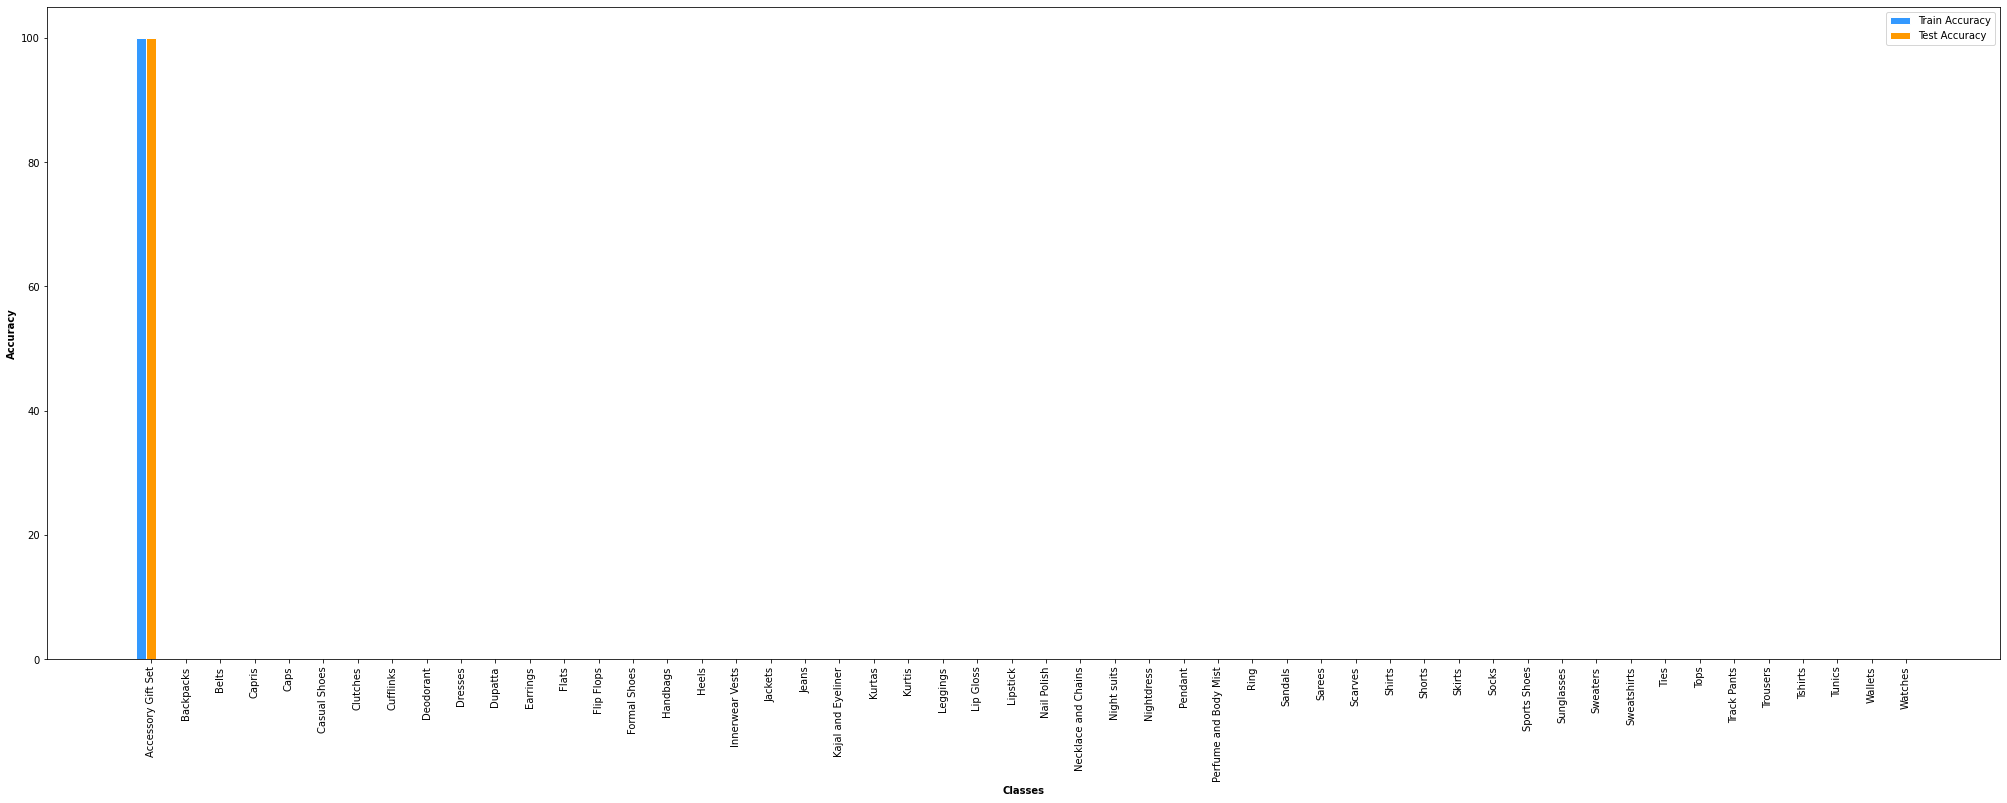

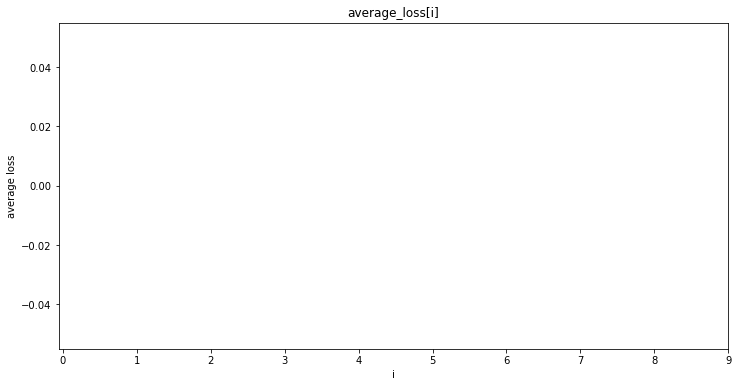

In [ ]:
showPartDetails(model, trainLoader, testLoader, avgLosses)

---
#Part 4

---
 
Main difference between this part and part 3 is transfomer function which is <u>ToTonser255</u>(). as mentioned in **Prelude**, this function does what ToTonsor1() does, plus, maps values [0,255] to [0,1].

**Results** : 

part -> (accuracy, final loss, training time(mins))

part3 : (~ 0.3%, nan, 2.15)

part4 : (~ 54.1%, 1.273, 2.18)

**Why?**

If we don't divide our image vectors by 255, we will get a very bad accuracy and loss will be nan.

First reason is that normalization (here divide by 255) will help us to remove distortions caused by lights and shadows in an image. so it might results better using normalized transformers.

Second, without normalization we would have intergers between 0 to 255 which makes big differences between features, while numbers in range of [0,1] clarify differences in a more moderate way.

And third, I think that nan in loss value is because of large range of [0, 255] which leads to big errors because weights are getting kind of exploded. 

---

In [ ]:
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, 0.01, 64, 10, 16)

In [ ]:
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)

epoch 1, trainLoss: 3.316, time elapsed: 13.173188 seconds
epoch 2, trainLoss: 2.587, time elapsed: 13.0884 seconds
epoch 3, trainLoss: 2.122, time elapsed: 13.13083 seconds
epoch 4, trainLoss: 1.824, time elapsed: 13.087769 seconds
epoch 5, trainLoss: 1.656, time elapsed: 13.112231 seconds
epoch 6, trainLoss: 1.531, time elapsed: 13.133109 seconds
epoch 7, trainLoss: 1.464, time elapsed: 13.22534 seconds
epoch 8, trainLoss: 1.397, time elapsed: 13.122357 seconds
epoch 9, trainLoss: 1.328, time elapsed: 13.115517 seconds
epoch 10, trainLoss: 1.273, time elapsed: 13.181025 seconds
total training time: 2.189 minutes


          _  Train   Test
0  Accuracy  54.37  54.10


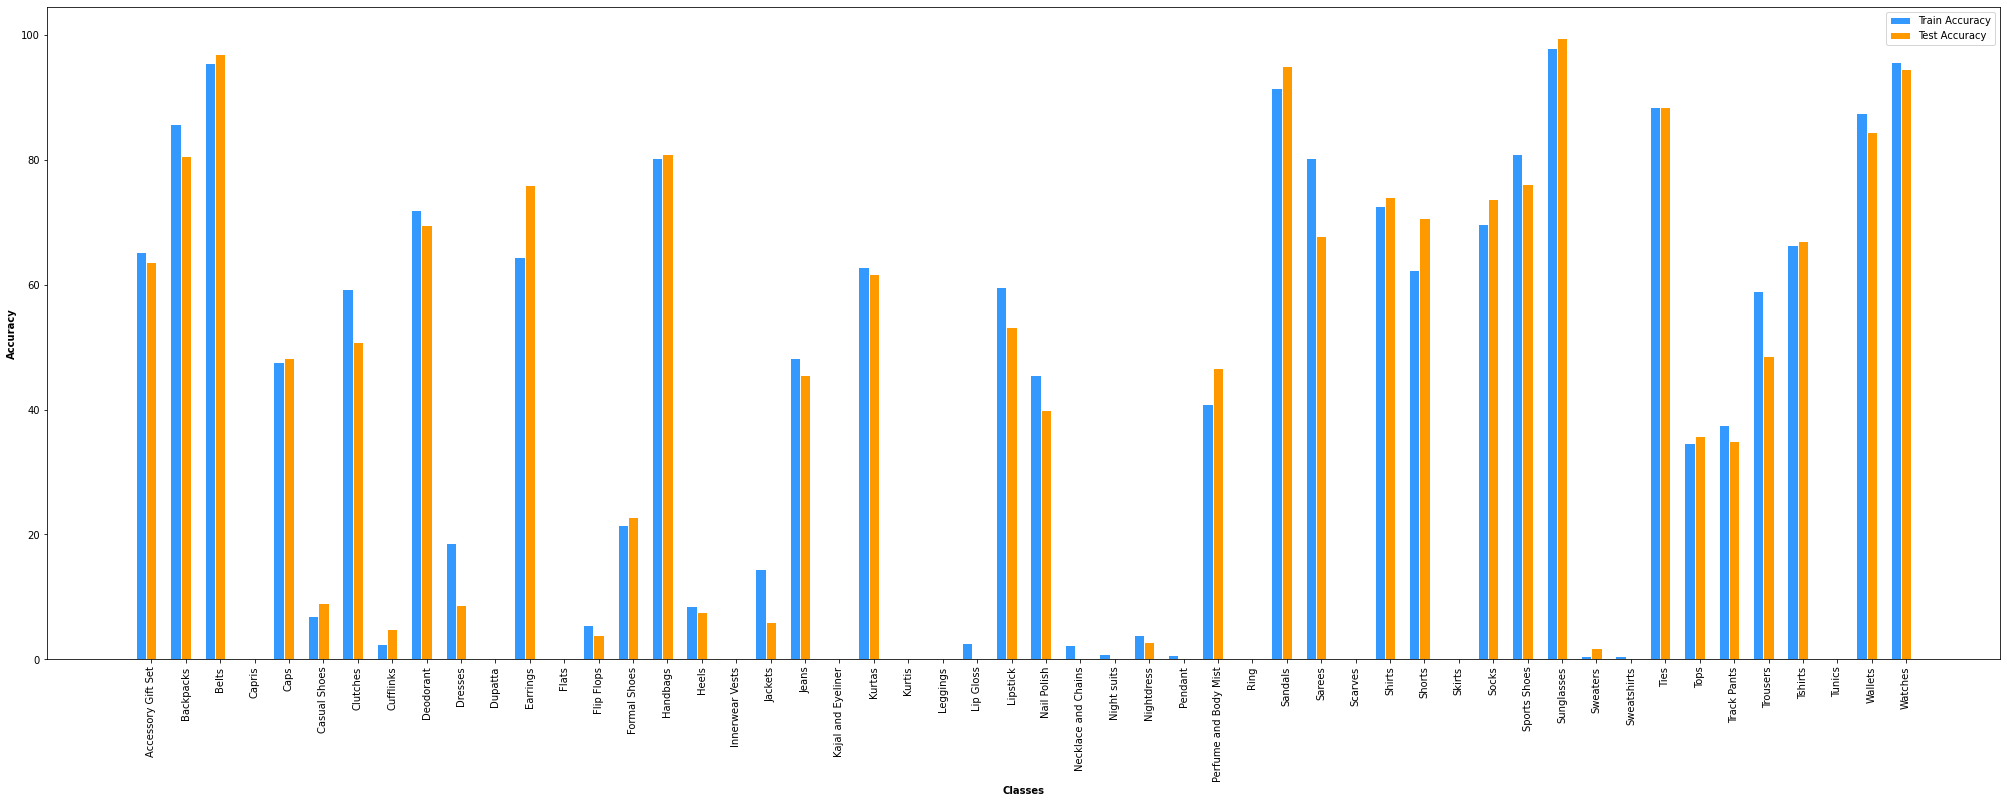

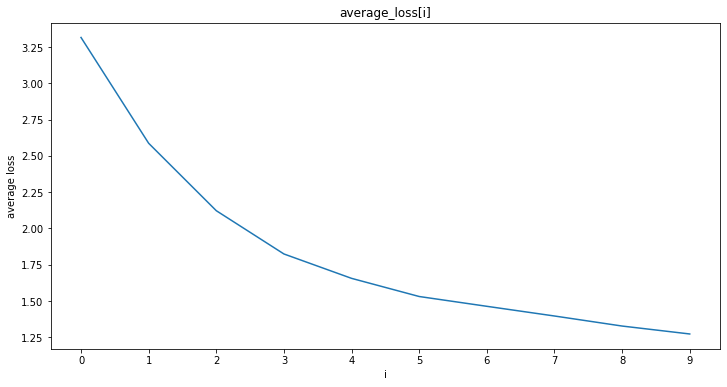

In [ ]:
showPartDetails(model, trainLoader, testLoader, avgLosses)

---
#Part 5

---
 
##5A:

To initialize weights with zero values instead of random values (i.e. default), we rewrite <u>Model</u> class and set weights zero with these two lines per every layer :

```
self.layerX.weight.data.fill_(0)
self.layerX.bias.data.fill_(0)
```
**Results :**

Part -> (accuracy, final loss, trainig time(mins))

Part 4 : (~ 54.1%, 1.273, 2.18)

Part 5 : (~ 9.5%, 3.513, 2.18)

**Results were completely different from part 4. Why?**

In part 4 we used random weights, and per every new batch we read, we back-propagated and updated these weights considering learning rate as a determinative. So starting with random weights gave us a good accuracy due to better probability of gaining almost-right weights in comparison to zero weights.

In another words, by using zero weights, its harder to gain better results, because :
1.   If all the weights are initialized with zero-value, all weights have the same value in subsequent iterations. This makes hidden units symmetric and continues for all the n iterations i.e. This model would work like a linear model.
2.   Starting with zero weigths make updates harder because at first back-propagations, weights don't affect and it could results a bias on weights. (as we see in accuracy per classes in part 5)
3.   Learning rate is usually small to change zero to currect weight. 
4.   True weights are usually non-zero values, so starting with non-zero weights would help)

---
##5B:
As we saw, initializing with zero-value weights, results are not satisfying, plus, using random values might works well of not. Two main issues using random weights are: 


*   **Vanishing gradients :** For any activation function, <u>dW (changes in w)</u> will get smaller and smaller, and this would make back-propagations slower and slower and finally, this may completely stop the neural network from training further.
*   **Exploding gradients :** Opposite of vanishing, if we have large weights and small activations, <u>dW</u> would be huge. It might overshoot the optimum again and again and the model will never learn.

So we need some techniques : (some of these are related to [this link](https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94), and some are my own opinions) : 


1.   **Using relu and leaky-relu as activation function:** because they are relatively robust to the vanishing/exploding gradient issues.
2.   **Using a heuristic to initialize weights (with non-linear activation functions):** for example multiplying random initialization with some values : W[l] : <mark>He initialization: np.sqrt(2 / size^(l-1)) for relu</mark> or <mark>Xavier initialization: np.sqrt(2 / size^(l-1)) for tanh</mark> or ...
3.   **Gradient clipping:** means setting a threshold to avoid exploding gradient.
4.   **(my own opinion) Pre-trainded models:** If our model is a common model we might be able to use a pre-trained model as an initialization for weights, then by freezing all layers except for last layer, we can continue our training.

---

In [ ]:
class Model(nn.Module):
    def __init__(self, numOfClasses, actFunction=F.relu):
        super(Model, self).__init__()
        
        self.layer1 = nn.Linear(1 * 80 * 60, 16 * 40 * 30)
        self.layer1.weight.data.fill_(0)
        self.layer1.bias.data.fill_(0)
        self.act1 = actFunction

        self.layer2 = nn.Linear(16 * 40 * 30, 48 * 12 * 10)
        self.layer2.weight.data.fill_(0)
        self.layer2.bias.data.fill_(0)
        self.act2 = actFunction

        self.layer3 = nn.Linear(48 * 12 * 10, 96 * 4 * 5)
        self.layer3.weight.data.fill_(0)
        self.layer3.bias.data.fill_(0)
        self.act3 = actFunction

        self.layer4 = nn.Linear(96 * 4 * 5, 256)
        self.layer4.weight.data.fill_(0)
        self.layer4.bias.data.fill_(0)
        self.act4 = actFunction

        self.layer5 = nn.Linear(256, numOfClasses)
        self.layer5.weight.data.fill_(0)
        self.layer5.bias.data.fill_(0)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [ ]:
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, 0.01, 64, 10, 16)

In [ ]:
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)

epoch 1, trainLoss: 3.895, time elapsed: 13.086147 seconds
epoch 2, trainLoss: 3.798, time elapsed: 13.021395 seconds
epoch 3, trainLoss: 3.721, time elapsed: 13.078883 seconds
epoch 4, trainLoss: 3.661, time elapsed: 13.076634 seconds
epoch 5, trainLoss: 3.617, time elapsed: 13.149458 seconds
epoch 6, trainLoss: 3.583, time elapsed: 13.072783 seconds
epoch 7, trainLoss: 3.557, time elapsed: 13.052796 seconds
epoch 8, trainLoss: 3.539, time elapsed: 13.055769 seconds
epoch 9, trainLoss: 3.525, time elapsed: 13.088111 seconds
epoch 10, trainLoss: 3.513, time elapsed: 13.071913 seconds
total training time: 2.179 minutes


          _ Train  Test
0  Accuracy  9.48  9.51


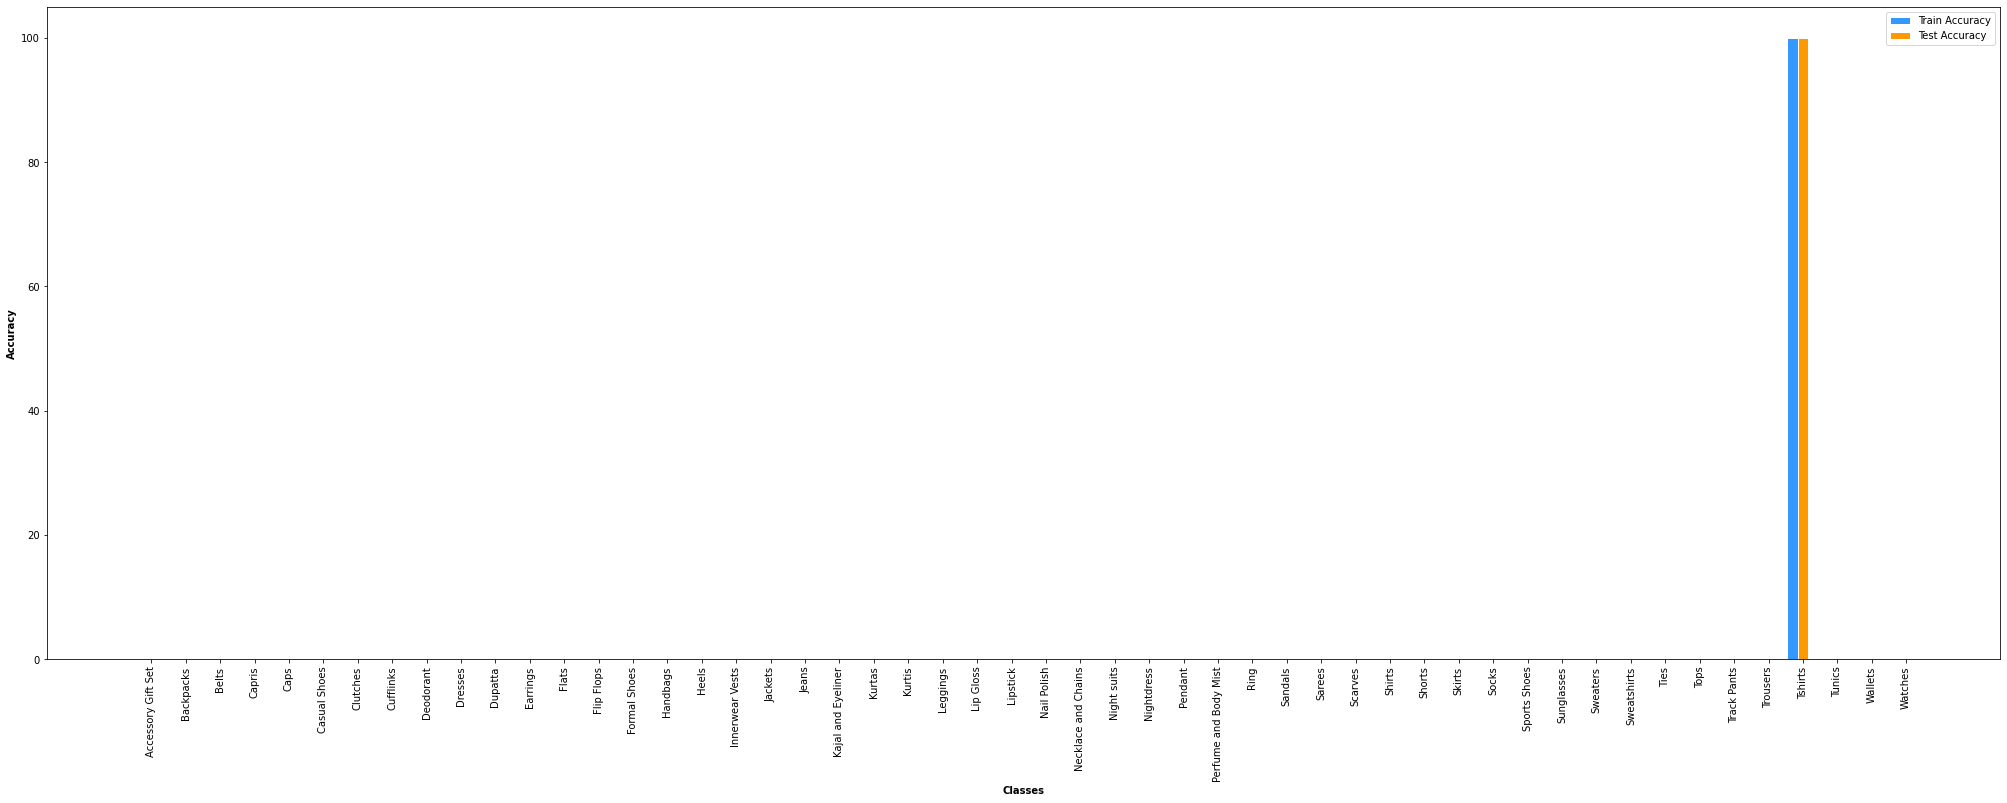

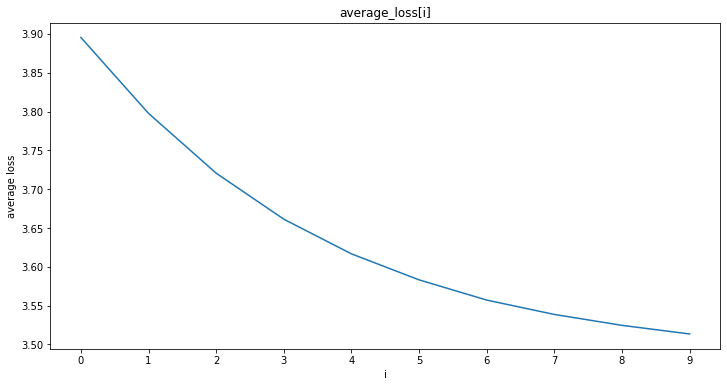

In [ ]:
showPartDetails(model, trainLoader, testLoader, avgLosses)

---
#Part 6

---
 
##6A:

In this part, we test multiple values for **learning rate** . results are shown beneath, but in brief:

learning rate -> [train accuracy, test accuracy, final loss]

0.00125 -> [26.90% , 27.05%, 2.654]

0.0025 -> [34.03% , 33.8%, 1.961]

0.005 -> [41.45%, 41.01%, 1.523]

0.01 -> [54.37%, 54.10%, 1.273]

0.02 -> [47.56%, 47.52%, 1.115]

0.04 -> [23.41%, 23.32%, 1.024]

0.08 -> [31.58%, 31.97%, 2.217]

All training times were almost the same.

So based on these values, <mark>Learning Rate optimum value for my model is = 0.01</mark>

---

In [ ]:
# back to previous model
class Model(nn.Module):
    def __init__(self, numOfClasses, actFunction=F.relu):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 16 * 40 * 30)
        self.act1 = actFunction

        self.layer2 = nn.Linear(16 * 40 * 30, 48 * 12 * 10)
        self.act2 = actFunction

        self.layer3 = nn.Linear(48 * 12 * 10, 96 * 4 * 5)
        self.act3 = actFunction

        self.layer4 = nn.Linear(96 * 4 * 5, 256)
        self.act4 = actFunction

        self.layer5 = nn.Linear(256, numOfClasses)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [ ]:
def checkDifferentLRs() : 
  coefs = [2, 4, 8]
  base = 0.01
  # bigger learning rates
  print("Bigger learning rates...")
  for lr in coefs : 
    print("learning rate : ", base * lr)
    [activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, base * lr, 64, 10, 16)
    avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
    showPartDetails(model, trainLoader, testLoader, avgLosses)

  # smaller learning rates
  print("Smaller learning rates...")
  for lr in coefs : 
    print("learning rate : ",  base * float(1/lr))
    [activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, base * float(1/lr), 64, 10, 16)
    avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
    showPartDetails(model, trainLoader, testLoader, avgLosses)


Bigger learning rates...
learning rate :  0.02
epoch 1, trainLoss: 3.041, time elapsed: 13.091735 seconds
epoch 2, trainLoss: 2.143, time elapsed: 13.129824 seconds
epoch 3, trainLoss: 1.778, time elapsed: 13.084166 seconds
epoch 4, trainLoss: 1.591, time elapsed: 13.054361 seconds
epoch 5, trainLoss: 1.460, time elapsed: 13.065971 seconds
epoch 6, trainLoss: 1.357, time elapsed: 13.101446 seconds
epoch 7, trainLoss: 1.275, time elapsed: 13.069436 seconds
epoch 8, trainLoss: 1.213, time elapsed: 13.098189 seconds
epoch 9, trainLoss: 1.165, time elapsed: 13.104983 seconds
epoch 10, trainLoss: 1.115, time elapsed: 13.092993 seconds
total training time: 2.182 minutes
          _  Train   Test
0  Accuracy  47.56  47.52


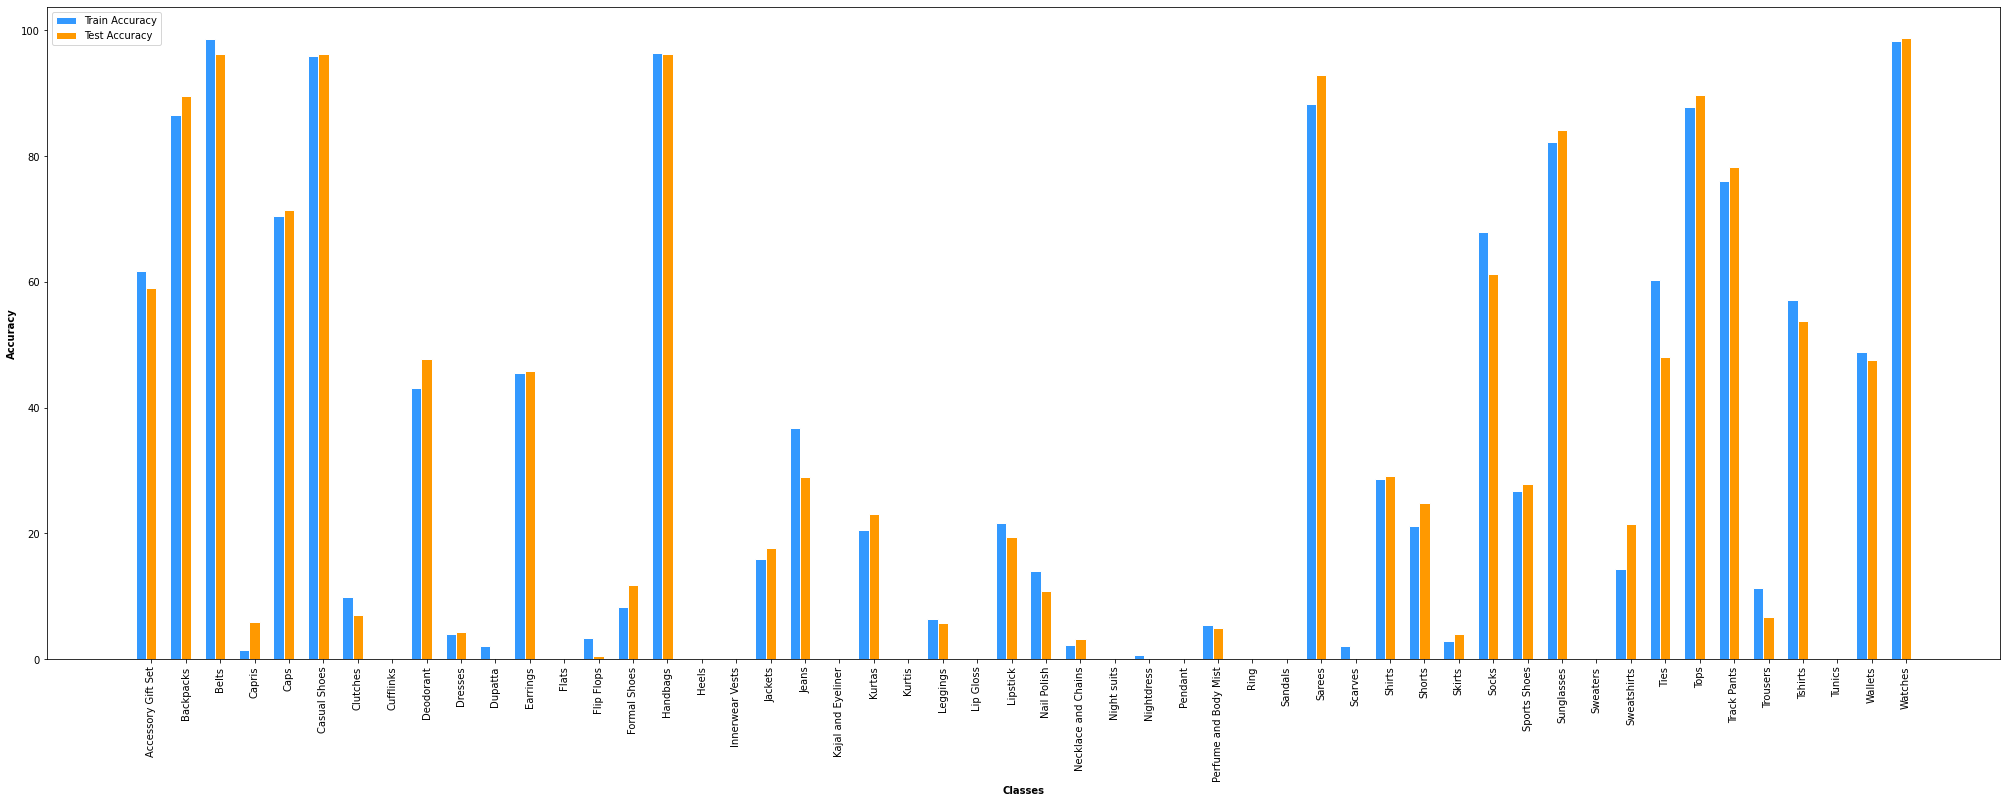

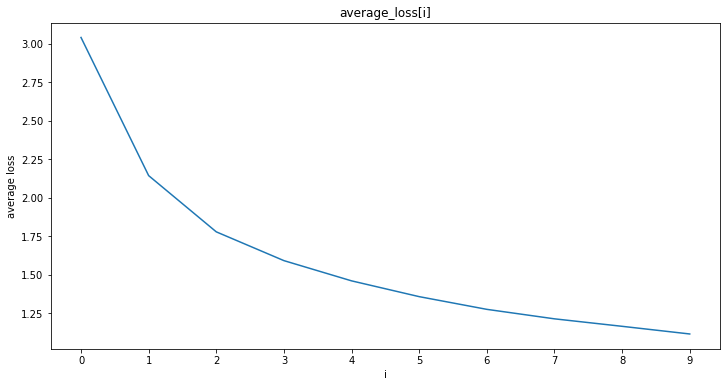

learning rate :  0.04
epoch 1, trainLoss: 2.802, time elapsed: 13.295326 seconds
epoch 2, trainLoss: 1.974, time elapsed: 13.255831 seconds
epoch 3, trainLoss: 1.638, time elapsed: 13.260042 seconds
epoch 4, trainLoss: 1.435, time elapsed: 13.403784 seconds
epoch 5, trainLoss: 1.378, time elapsed: 13.279524 seconds
epoch 6, trainLoss: 1.267, time elapsed: 13.261253 seconds
epoch 7, trainLoss: 1.180, time elapsed: 13.288061 seconds
epoch 8, trainLoss: 1.117, time elapsed: 13.265068 seconds
epoch 9, trainLoss: 1.078, time elapsed: 13.438161 seconds
epoch 10, trainLoss: 1.024, time elapsed: 13.276906 seconds
total training time: 2.217 minutes
          _  Train   Test
0  Accuracy  23.41  23.32


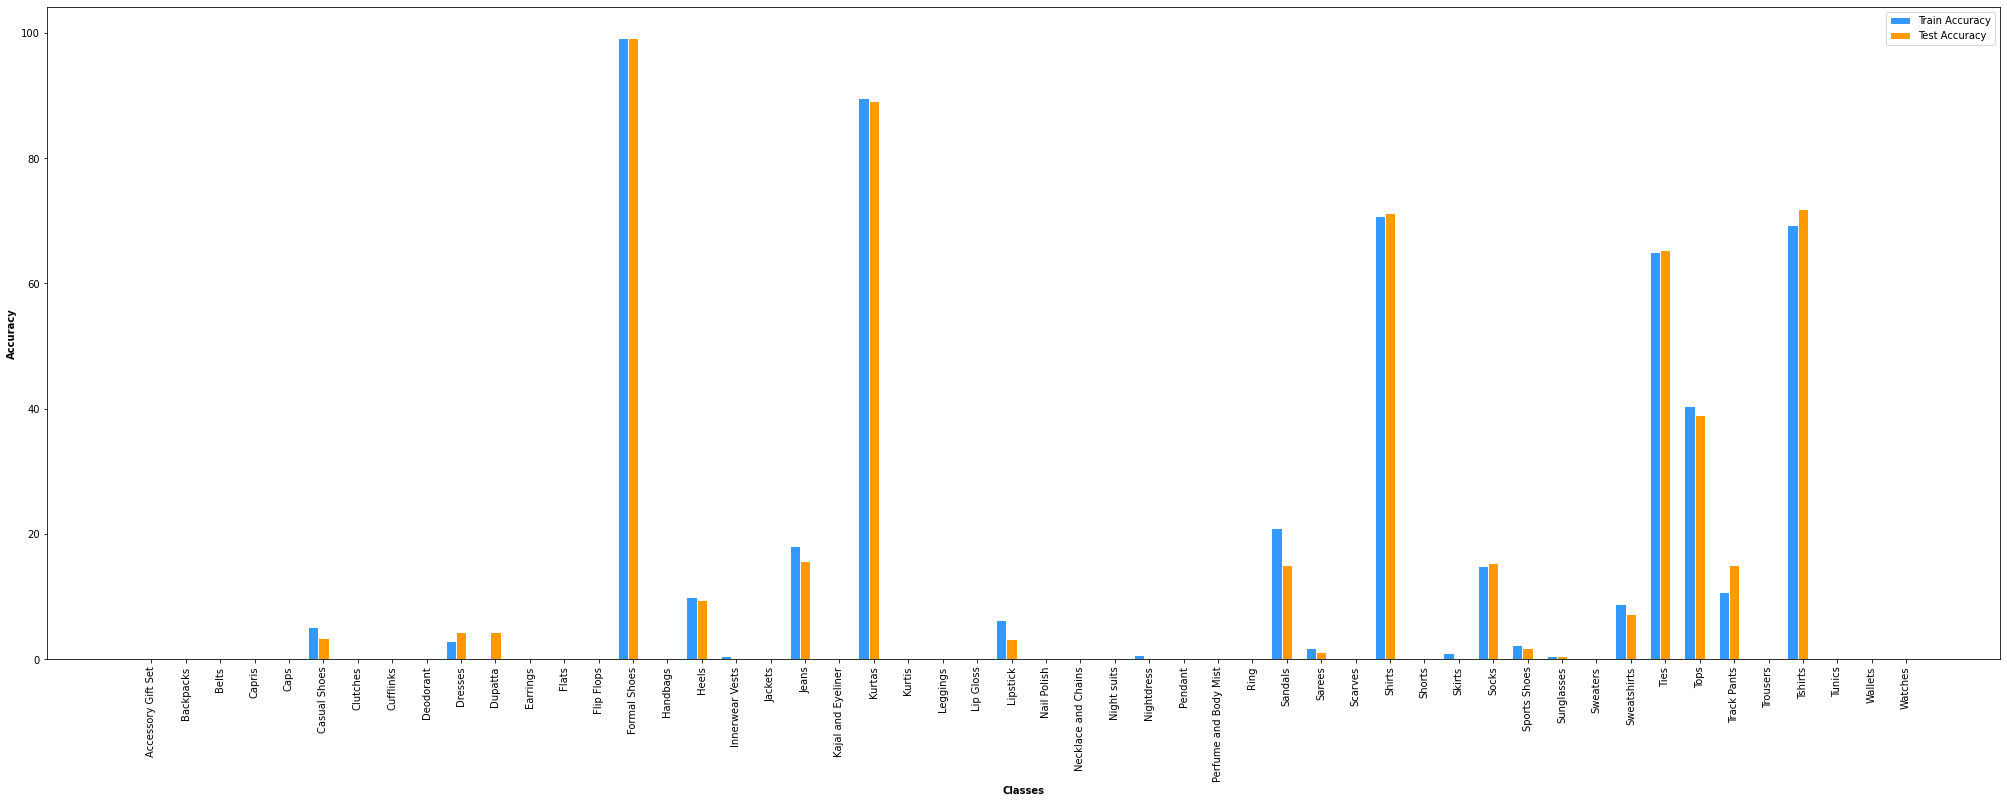

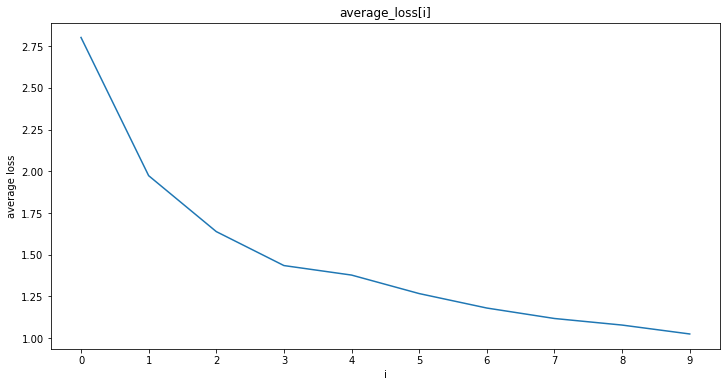

learning rate :  0.08
epoch 1, trainLoss: 2.714, time elapsed: 13.261769 seconds
epoch 2, trainLoss: 1.980, time elapsed: 13.279999 seconds
epoch 3, trainLoss: 1.647, time elapsed: 13.293531 seconds
epoch 4, trainLoss: 1.499, time elapsed: 13.264011 seconds
epoch 5, trainLoss: 1.357, time elapsed: 13.266112 seconds
epoch 6, trainLoss: 1.261, time elapsed: 13.282861 seconds
epoch 7, trainLoss: 1.190, time elapsed: 13.276973 seconds
epoch 8, trainLoss: 1.107, time elapsed: 13.327644 seconds
epoch 9, trainLoss: 1.067, time elapsed: 13.471199 seconds
epoch 10, trainLoss: 1.093, time elapsed: 13.308295 seconds
total training time: 2.217 minutes
          _  Train   Test
0  Accuracy  31.58  31.97


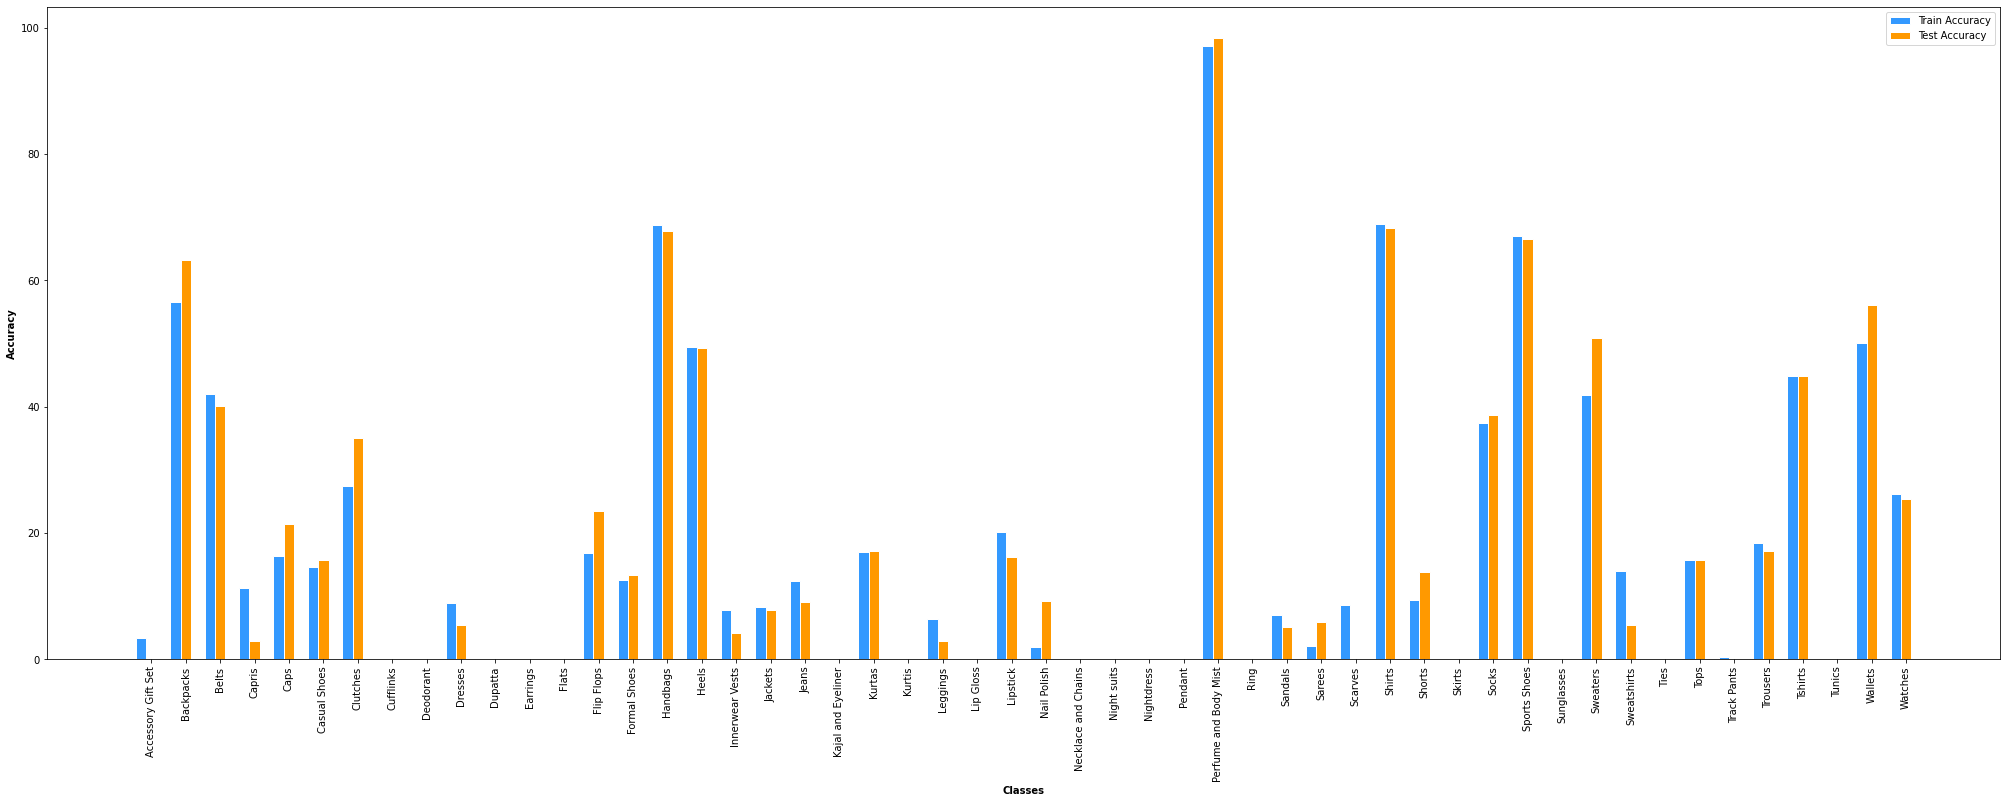

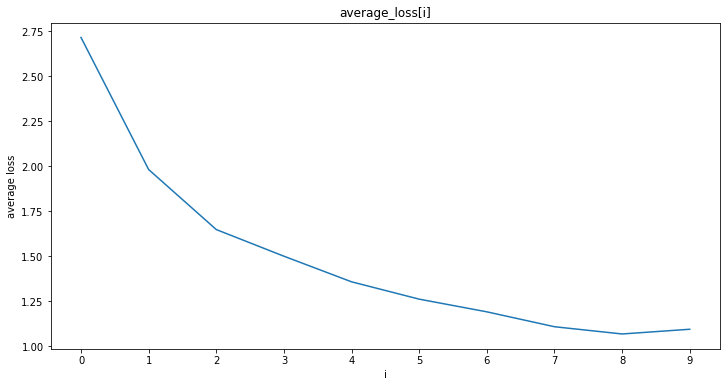

Smaller learning rates...
learning rate :  0.005
epoch 1, trainLoss: 3.553, time elapsed: 13.304393 seconds
epoch 2, trainLoss: 3.046, time elapsed: 13.270465 seconds
epoch 3, trainLoss: 2.614, time elapsed: 13.259319 seconds
epoch 4, trainLoss: 2.313, time elapsed: 13.361951 seconds
epoch 5, trainLoss: 2.091, time elapsed: 13.362152 seconds
epoch 6, trainLoss: 1.902, time elapsed: 13.283746 seconds
epoch 7, trainLoss: 1.776, time elapsed: 13.294863 seconds
epoch 8, trainLoss: 1.665, time elapsed: 13.275665 seconds
epoch 9, trainLoss: 1.594, time elapsed: 13.296322 seconds
epoch 10, trainLoss: 1.523, time elapsed: 13.310271 seconds
total training time: 2.217 minutes
          _  Train   Test
0  Accuracy  41.45  41.01


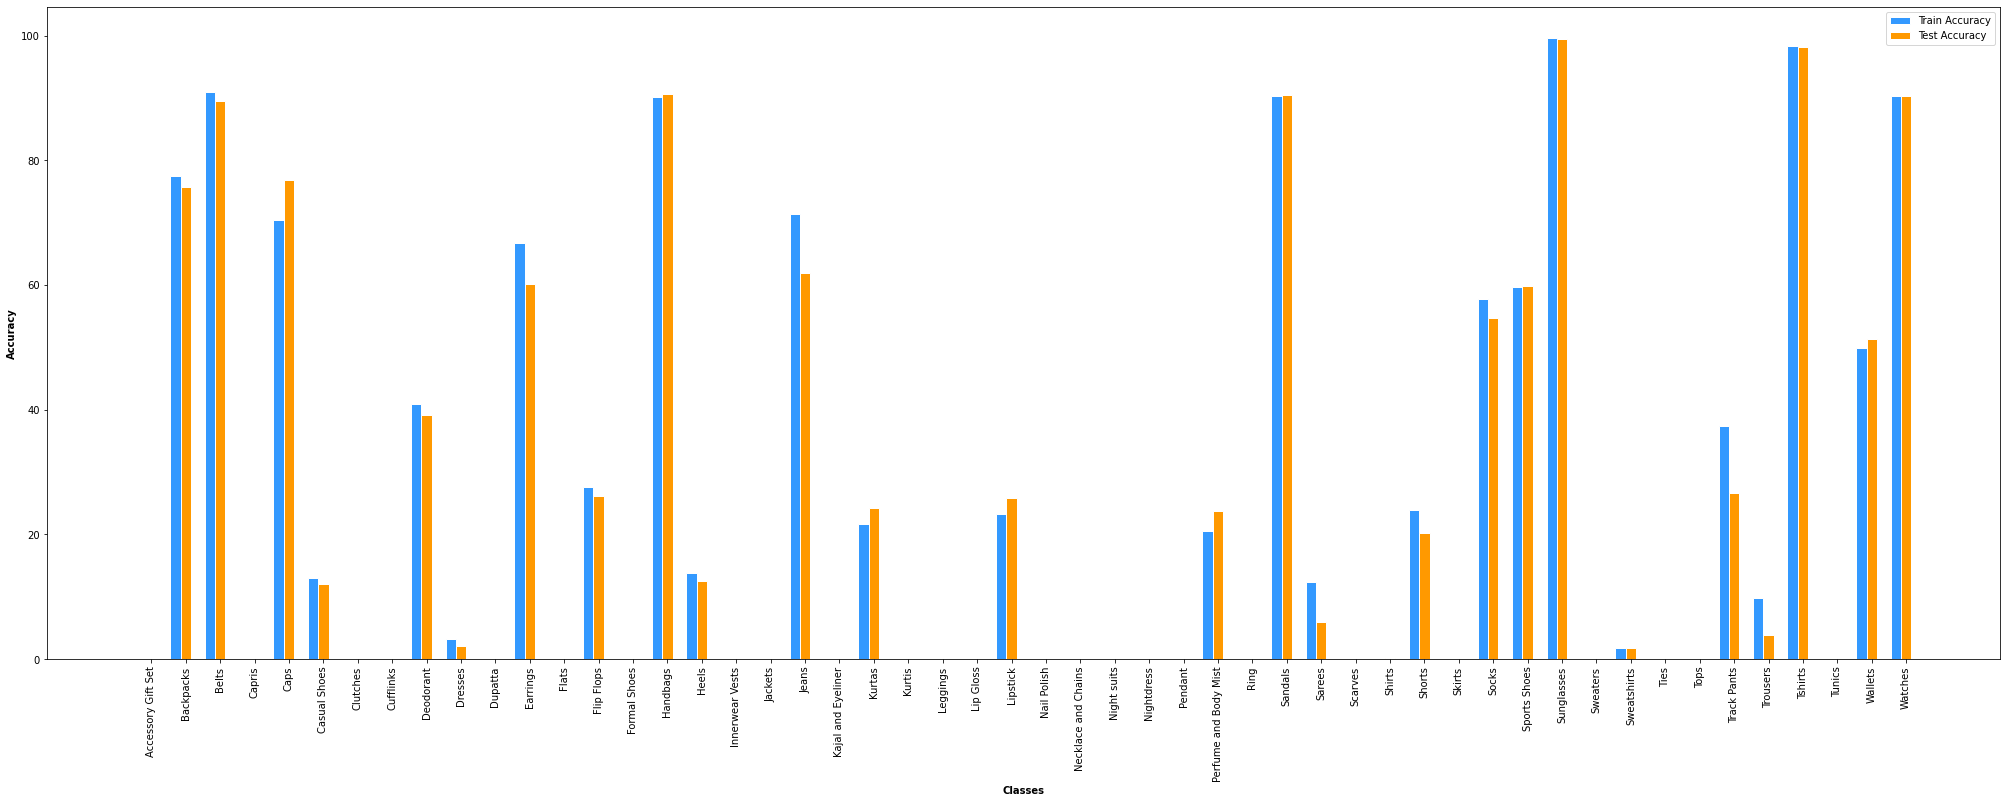

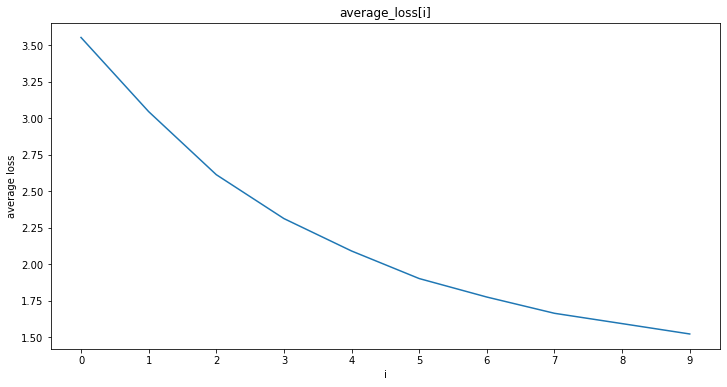

learning rate :  0.0025
epoch 1, trainLoss: 3.685, time elapsed: 13.277298 seconds
epoch 2, trainLoss: 3.399, time elapsed: 13.287686 seconds
epoch 3, trainLoss: 3.202, time elapsed: 13.332415 seconds
epoch 4, trainLoss: 2.895, time elapsed: 13.340867 seconds
epoch 5, trainLoss: 2.689, time elapsed: 13.290907 seconds
epoch 6, trainLoss: 2.511, time elapsed: 13.304037 seconds
epoch 7, trainLoss: 2.341, time elapsed: 13.3736 seconds
epoch 8, trainLoss: 2.192, time elapsed: 13.259177 seconds
epoch 9, trainLoss: 2.068, time elapsed: 13.280147 seconds
epoch 10, trainLoss: 1.961, time elapsed: 13.281109 seconds
total training time: 2.217 minutes
          _  Train   Test
0  Accuracy  34.03  33.80


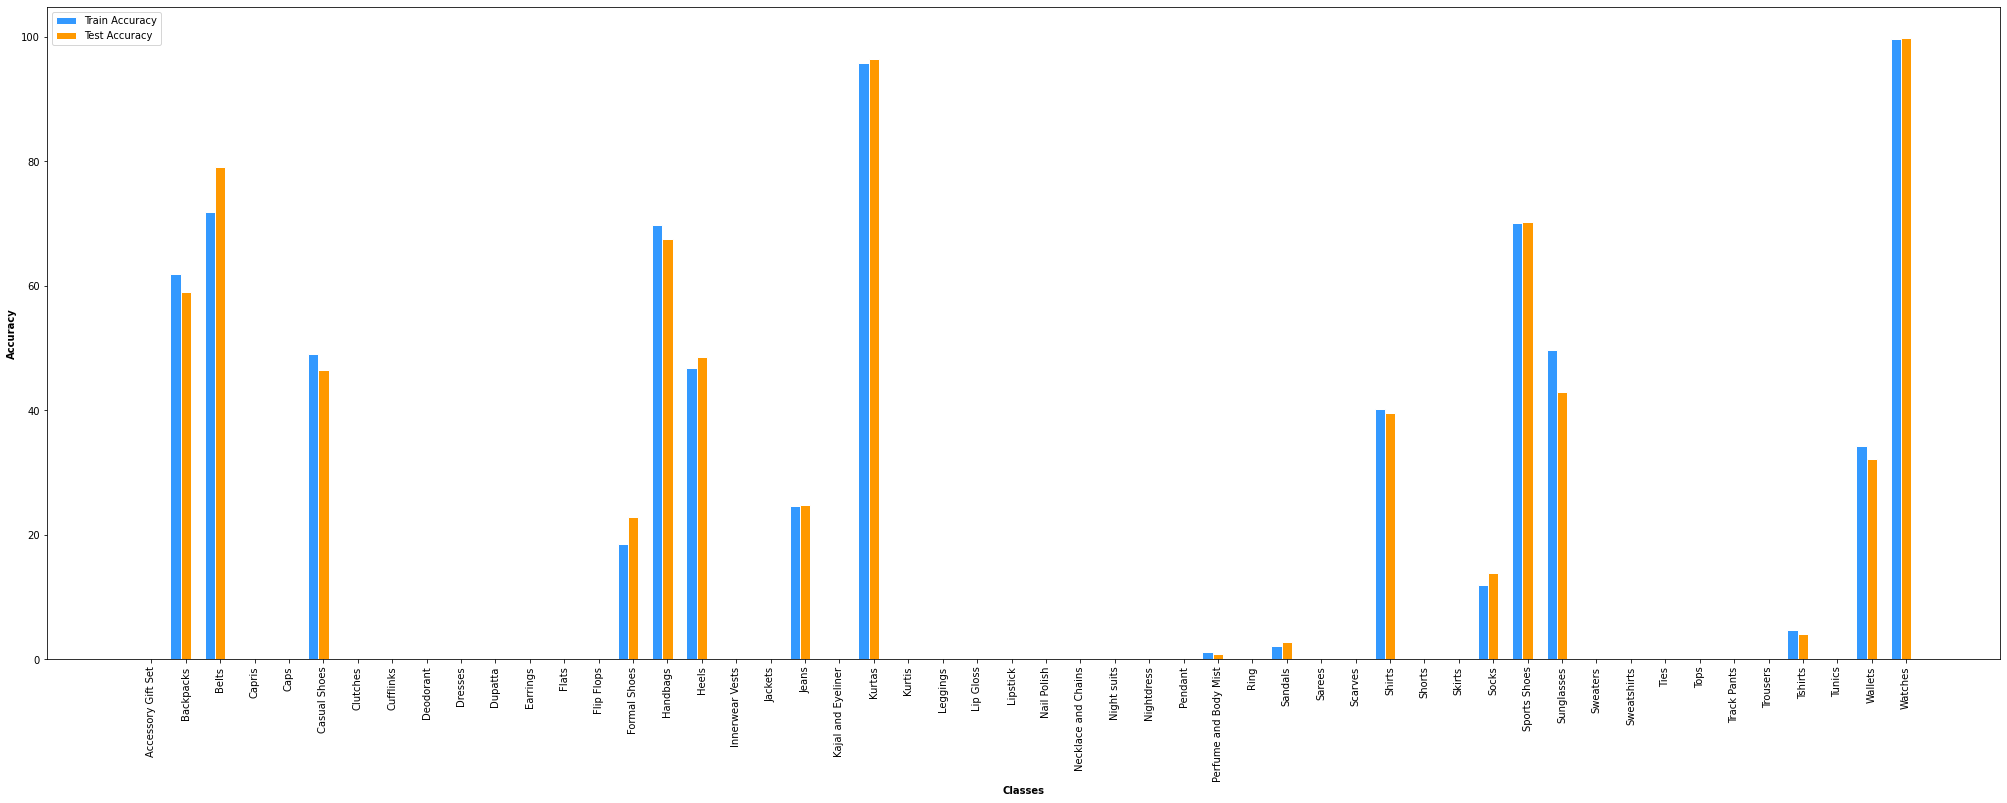

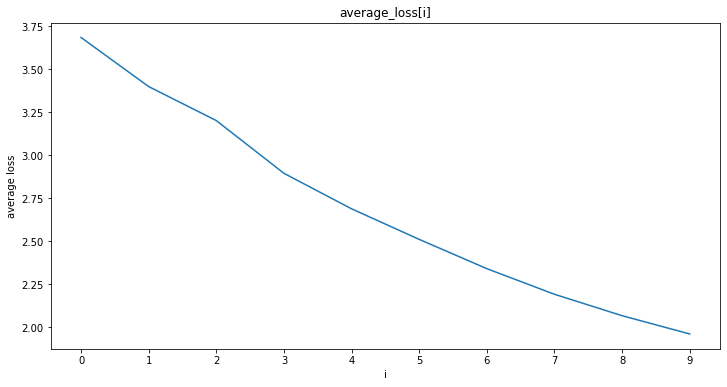

learning rate :  0.00125
epoch 1, trainLoss: 3.824, time elapsed: 13.34201 seconds
epoch 2, trainLoss: 3.498, time elapsed: 13.307827 seconds
epoch 3, trainLoss: 3.430, time elapsed: 13.284362 seconds
epoch 4, trainLoss: 3.388, time elapsed: 13.239923 seconds
epoch 5, trainLoss: 3.312, time elapsed: 13.274604 seconds
epoch 6, trainLoss: 3.164, time elapsed: 13.293349 seconds
epoch 7, trainLoss: 2.992, time elapsed: 13.272713 seconds
epoch 8, trainLoss: 2.862, time elapsed: 13.304716 seconds
epoch 9, trainLoss: 2.751, time elapsed: 13.270553 seconds
epoch 10, trainLoss: 2.654, time elapsed: 13.261484 seconds
total training time: 2.214 minutes
          _  Train   Test
0  Accuracy  26.90  27.05


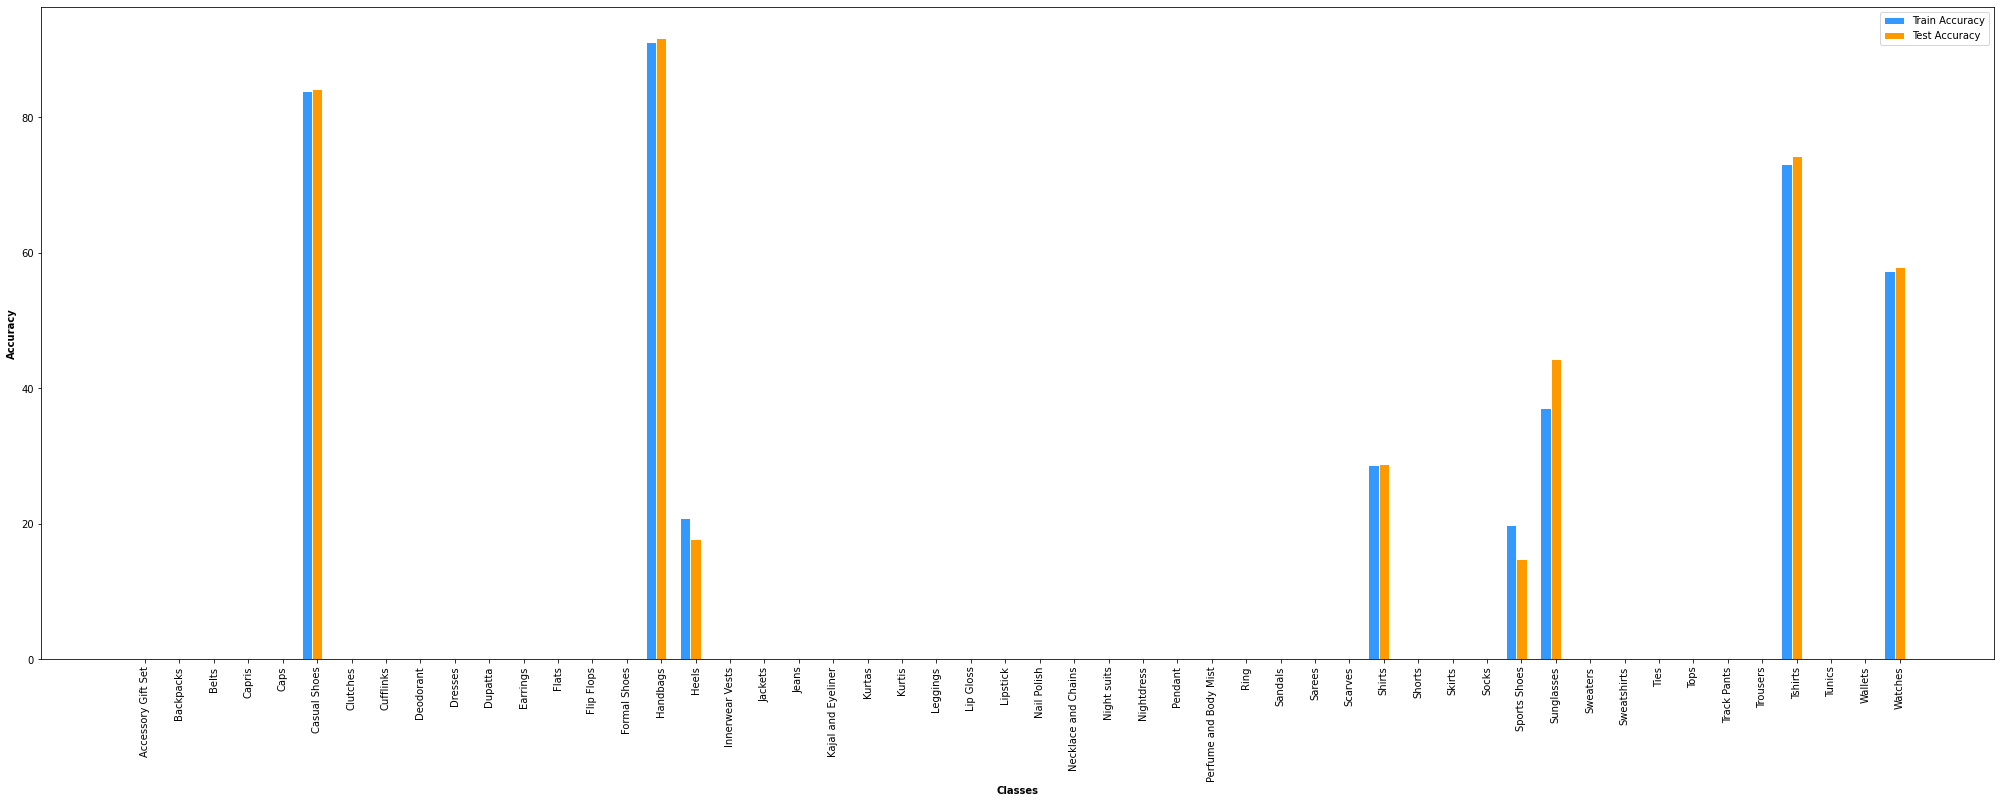

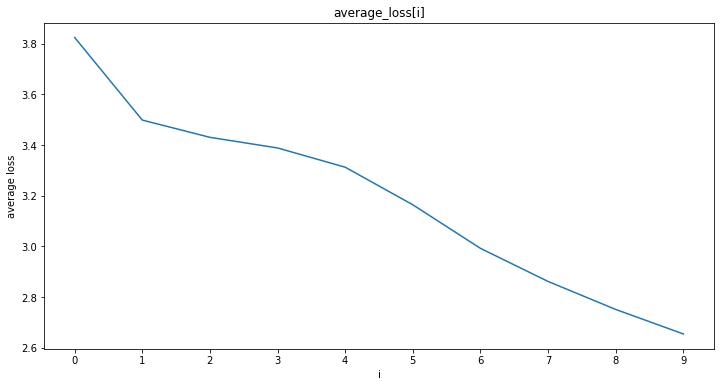

In [ ]:
checkDifferentLRs()

---
##6B:

learning rate -> (train accuracy, test accuracy, final loss)

0.001 -> (25.47%, 25.26%, 2.827)

0.1 -> (48.10%, 47.71%, 1.066)

**For big numbers like 0.1** : this learning rate is bigger than 0.01 which is the optimum value, so it will updates weights with bigger steps (<u>dW (changes of w)</u> would be bigger) so, during training, it might overshoot the optimum again and again and never reach the optimum accuracy, that's why total accuracy is less than 0.01.
As learnign rate increases, <u>dW</u> would get more huge and it might harm accuracy because of overshooting around optimum.

**For small numbers like 0.001** : this learning rate is smaller than 0.01 which is the optimum value, so, during training, <u>dW (changes in w)</u> will get smaller and smaller, and this would make back-propagations slower and slower and finally, this may completely stop the neural network from training further.  Even before reaching the optimum point. or it may reach optimum point but slower (need more epoches).

---

learning rate :  0.1
epoch 1, trainLoss: 2.814, time elapsed: 13.298691 seconds
epoch 2, trainLoss: 2.162, time elapsed: 13.306685 seconds
epoch 3, trainLoss: 1.910, time elapsed: 13.303139 seconds
epoch 4, trainLoss: 1.555, time elapsed: 13.276455 seconds
epoch 5, trainLoss: 1.388, time elapsed: 13.290187 seconds
epoch 6, trainLoss: 1.375, time elapsed: 13.287319 seconds
epoch 7, trainLoss: 1.304, time elapsed: 13.276981 seconds
epoch 8, trainLoss: 1.168, time elapsed: 13.338245 seconds
epoch 9, trainLoss: 1.120, time elapsed: 13.406534 seconds
epoch 10, trainLoss: 1.066, time elapsed: 13.301176 seconds
total training time: 2.218 minutes
          _  Train   Test
0  Accuracy  48.10  47.71


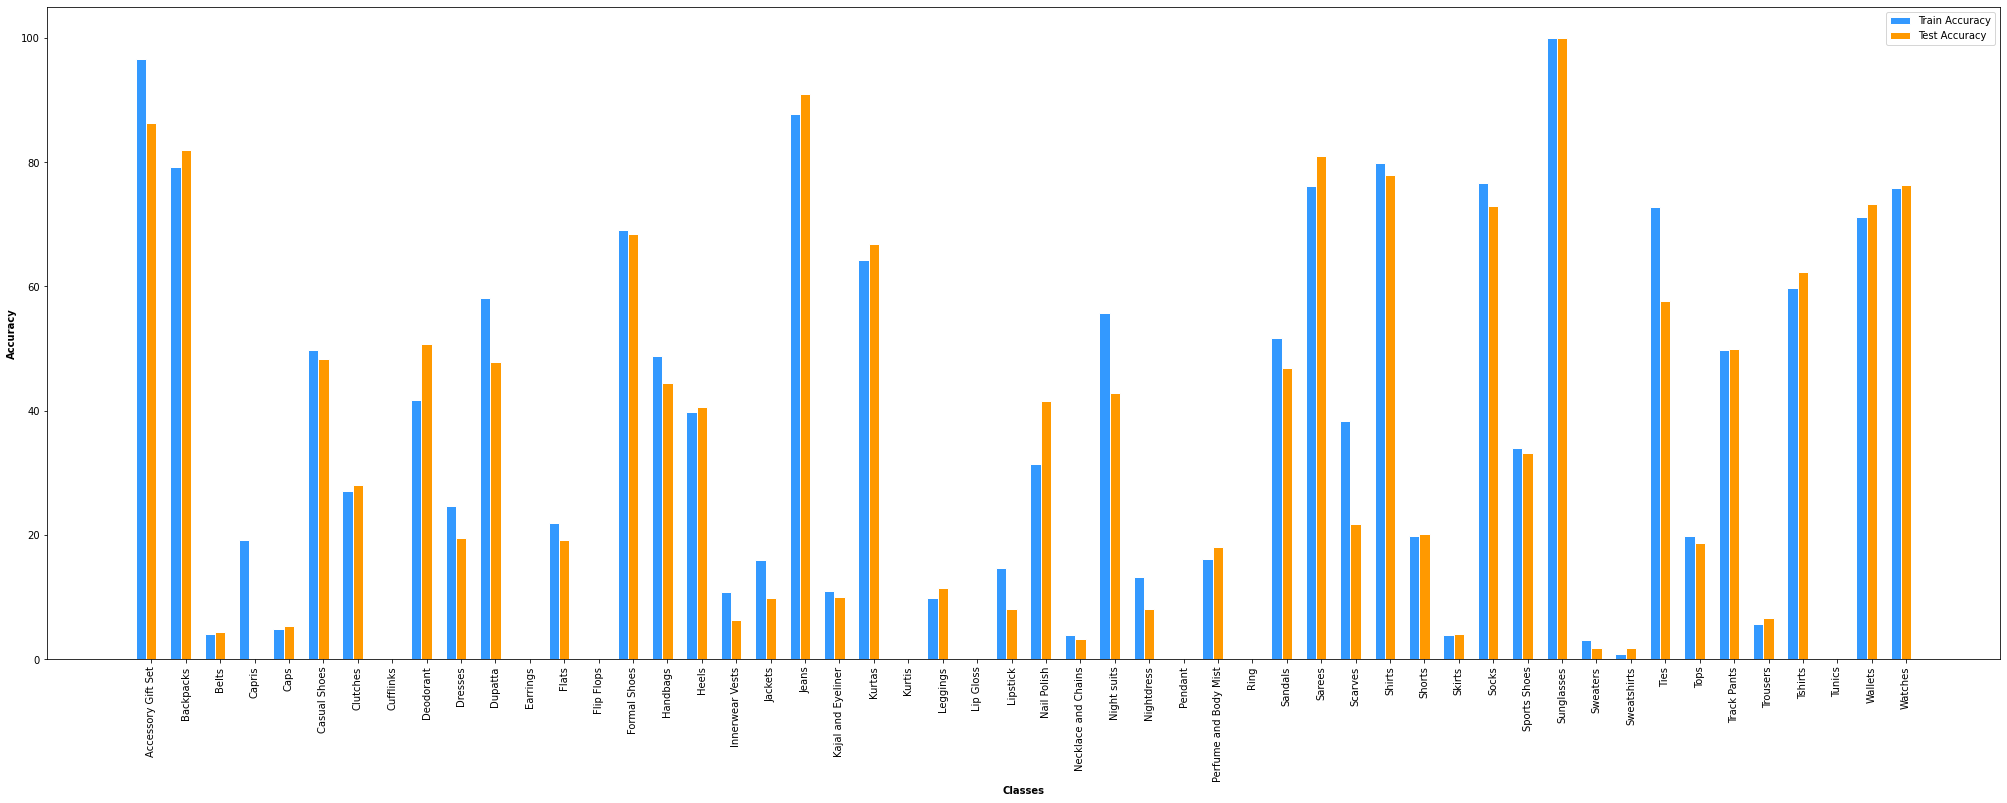

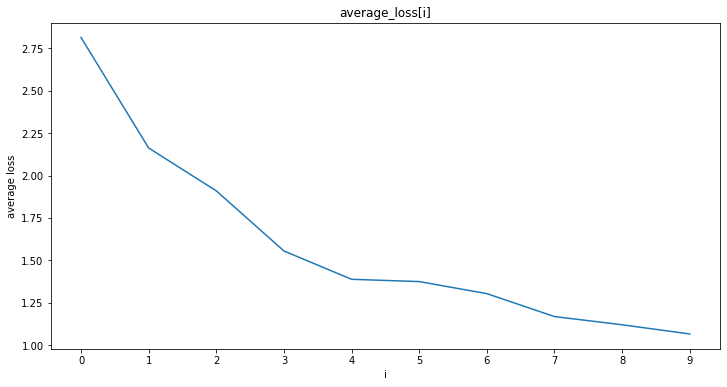

learning rate :  0.001
epoch 1, trainLoss: 3.879, time elapsed: 13.295944 seconds
epoch 2, trainLoss: 3.602, time elapsed: 13.28425 seconds
epoch 3, trainLoss: 3.451, time elapsed: 13.280572 seconds
epoch 4, trainLoss: 3.417, time elapsed: 13.309291 seconds
epoch 5, trainLoss: 3.381, time elapsed: 13.333858 seconds
epoch 6, trainLoss: 3.323, time elapsed: 13.266062 seconds
epoch 7, trainLoss: 3.219, time elapsed: 13.356821 seconds
epoch 8, trainLoss: 3.070, time elapsed: 13.26599 seconds
epoch 9, trainLoss: 2.935, time elapsed: 13.281216 seconds
epoch 10, trainLoss: 2.827, time elapsed: 13.397417 seconds
total training time: 2.218 minutes
          _  Train   Test
0  Accuracy  25.47  25.26


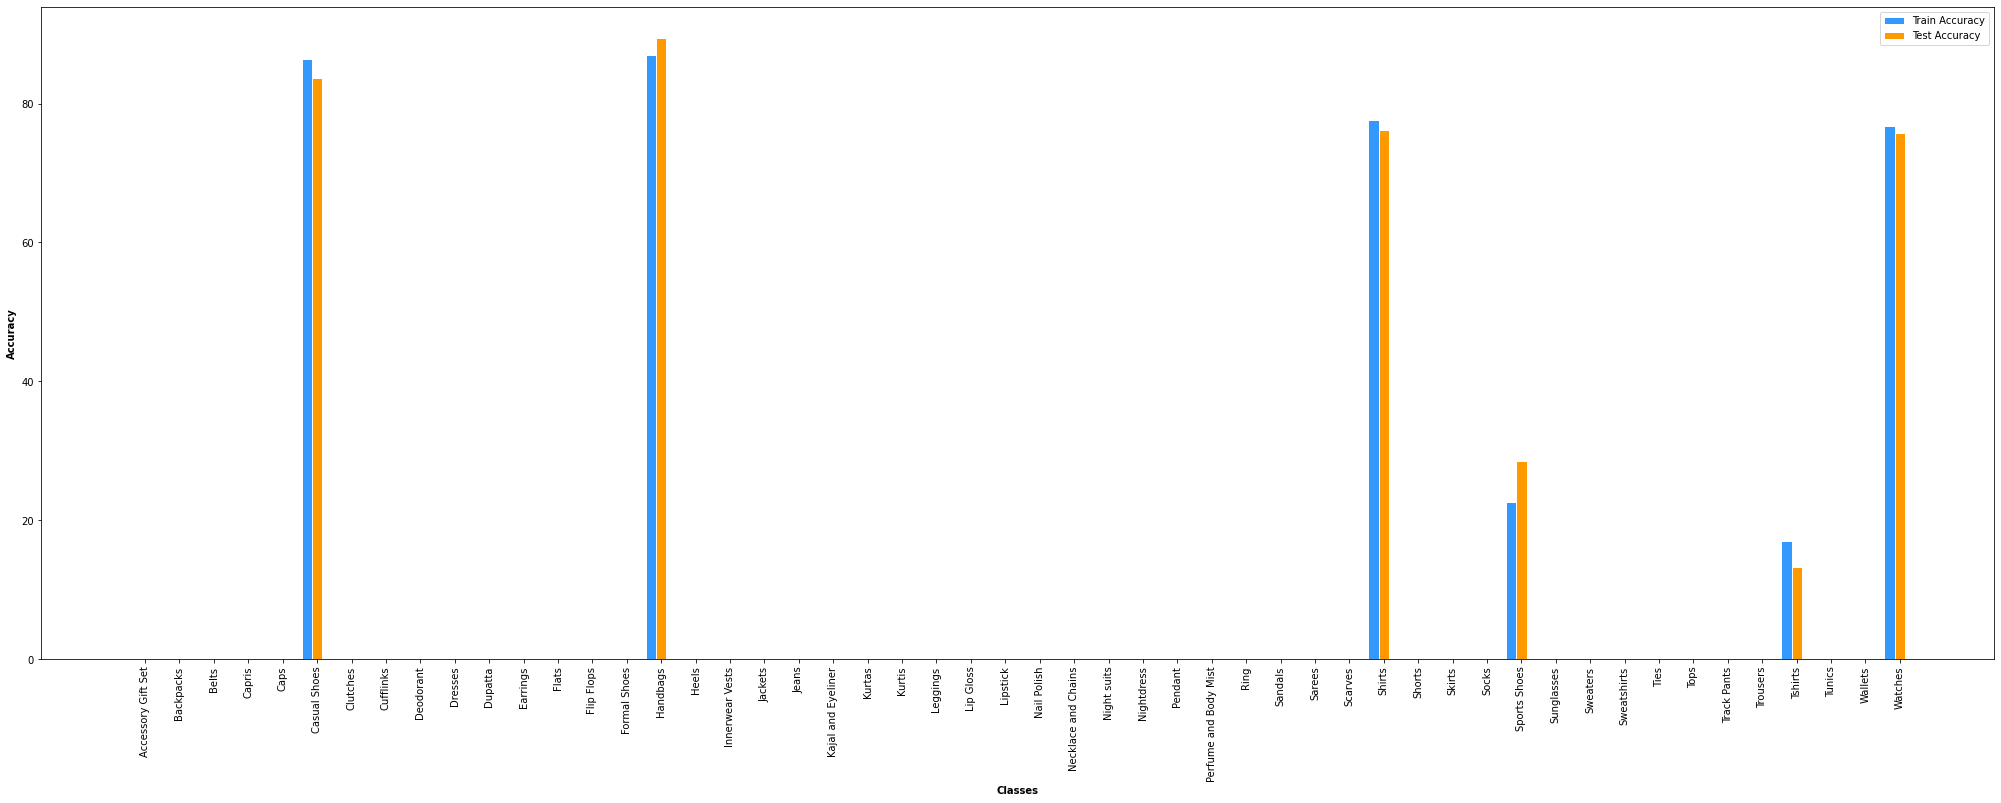

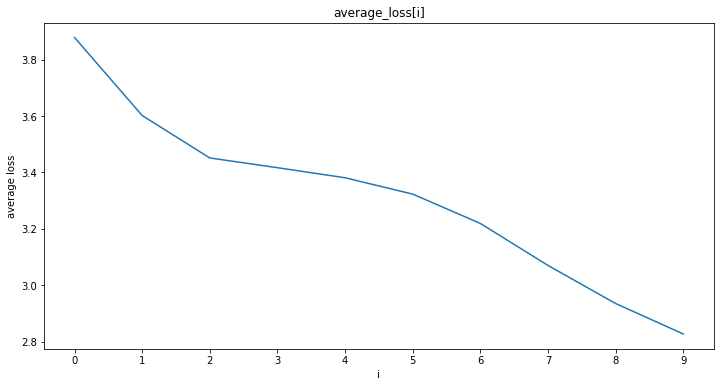

In [ ]:
optLr = 0.01
print("learning rate : ", 0.1)
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, 0.1, 64, 10, 16)
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
showPartDetails(model, trainLoader, testLoader, avgLosses)

print("learning rate : ", 0.001)
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, 0.001, 64, 10, 16)
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
showPartDetails(model, trainLoader, testLoader, avgLosses)

---
#Part 7
From now on we will use optimum learning rate...

---
 
##7A:

Here we go through testing batch sizes [32, 128] instead of 64 (set in part 3).

**Accuracies :** 

batch size -> [train accuracy, test accuracy, final loss, training time(mins)]

32 -> [40.69%, 39.93%, 1.069, 3.27]

64 -> [54.37%, 54.10%, 1.273, 2.18]

128 -> [45.44%, 45.63%, 1.597, 1.7]

**So, 64 is better than 128, and 128 is better than 32.**

<mark>Big batch size</mark> : 

Pros:

1.   Parallelization of stochastic gradient descent in deep learning.
2.   It might not stuch in local optimums (at least with lower probability than small batch sizes)
3.   It allows weights to go far away from intial values due to very big and very small updates.

Cons : 

1.   Increases computational cost because in every iteration it must handle more items.
2.   The lack of generalization (or poor generalization) ability due to the fact that large batch size methods tend to converge to sharp minimizers.

<mark>small batch size</mark> : 

Pros:

1.   Improves focussed learning
2.   Each batch being a “noisy” representation of the entire dataset (because we have a mini-batch), will cause a sort of “tug-and-pull” dynamic. This “tug-and-pull” dynamic prevents the neural network from overfitting on the training set.


Cons :

1.   It requires a lot of computing power because we will end up losing the “vectorization” or the stacking up of the weights in the process.
2.   Parallelization of stochastic gradient descent in deep learning is limited in case of small batch sizes and sequential iterations.
3.   It might not lead to global optimum answer.

**As a conclusion** large batch sizes lead to converge to sharp minimizers of training functions while small batch sizeslead to converge flat minimizers because of the noise in gradient estimation and The ideal size is to make it in the power of 2: 32, 64, 128, 256. This can improve training speed , because of how memory is laid out. Also, this will allow it to fit into GPU, and CPU memory.

**For our experiment**, 128 was better than 32 and its runtime was less too.

---

In [ ]:
def checkDifferentBatchSizes(batchSizes, learningRates) : 
  
  for bs in batchSizes : 
    for lr in learningRates :
      print("batch size : ", bs, " learning rate : ", lr)
      [activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, lr, bs, 10, 16)
      avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
      showPartDetails(model, trainLoader, testLoader, avgLosses)


batch size :  32  learning rate :  0.01
epoch 1, trainLoss: 3.003, time elapsed: 19.609462 seconds
epoch 2, trainLoss: 2.046, time elapsed: 19.621886 seconds
epoch 3, trainLoss: 1.690, time elapsed: 19.804492 seconds
epoch 4, trainLoss: 1.505, time elapsed: 19.623755 seconds
epoch 5, trainLoss: 1.375, time elapsed: 19.60988 seconds
epoch 6, trainLoss: 1.290, time elapsed: 19.645447 seconds
epoch 7, trainLoss: 1.221, time elapsed: 19.584849 seconds
epoch 8, trainLoss: 1.156, time elapsed: 19.603949 seconds
epoch 9, trainLoss: 1.112, time elapsed: 19.623215 seconds
epoch 10, trainLoss: 1.069, time elapsed: 19.603718 seconds
total training time: 3.272 minutes
          _  Train   Test
0  Accuracy  40.69  39.93


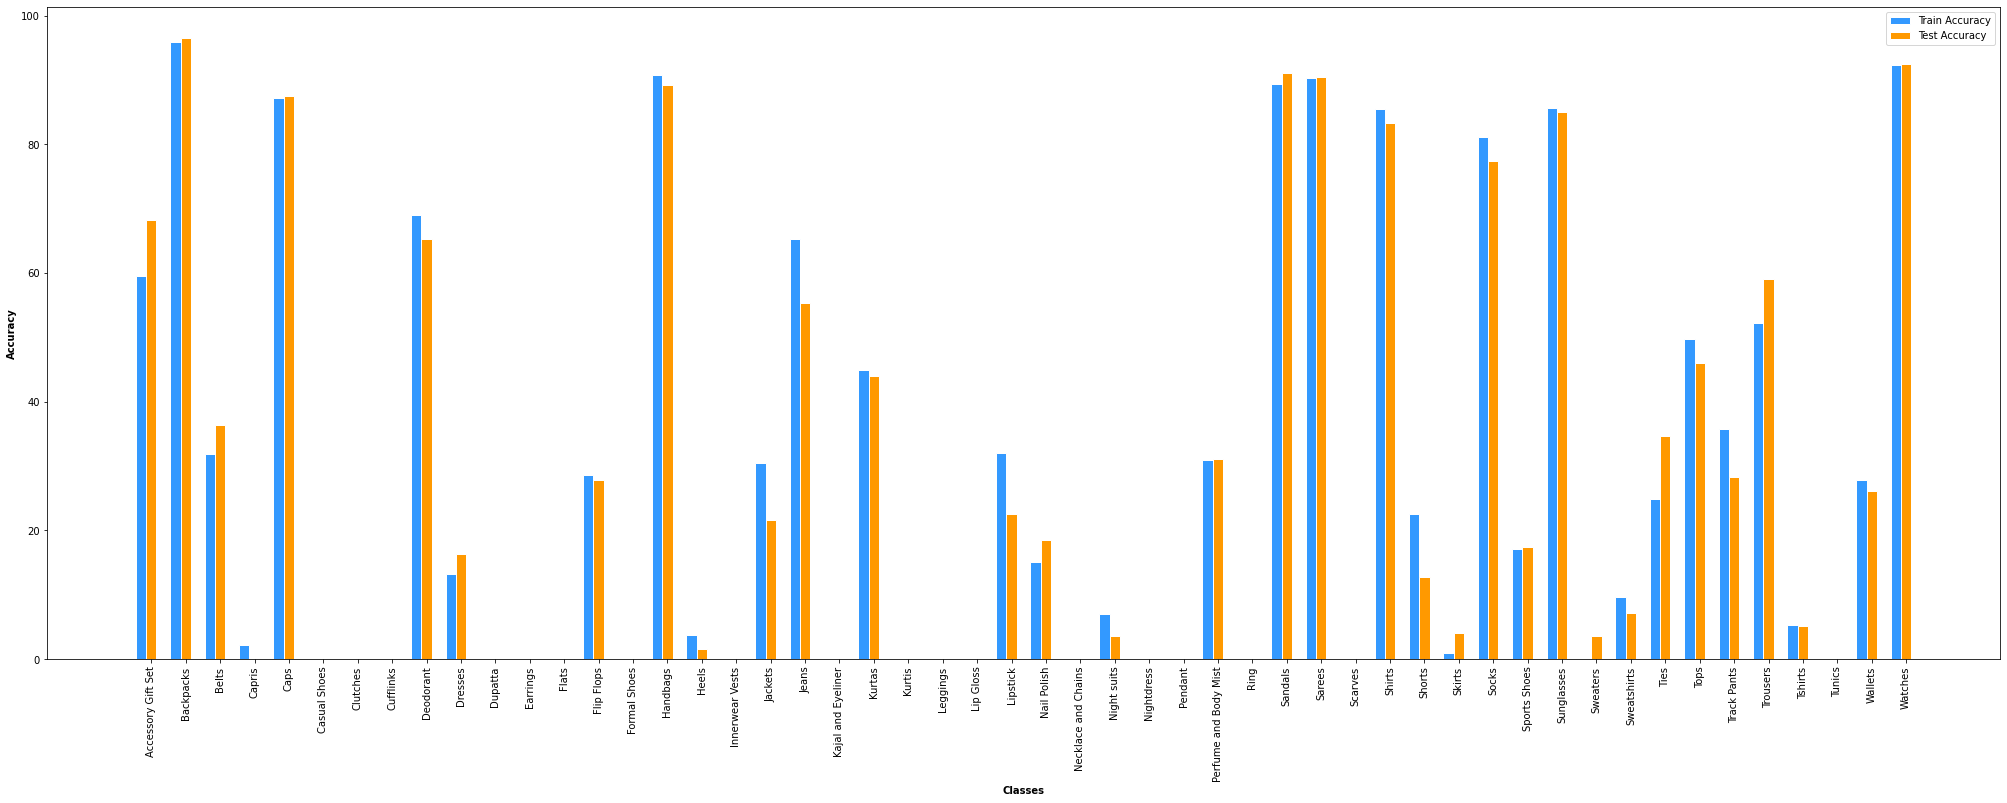

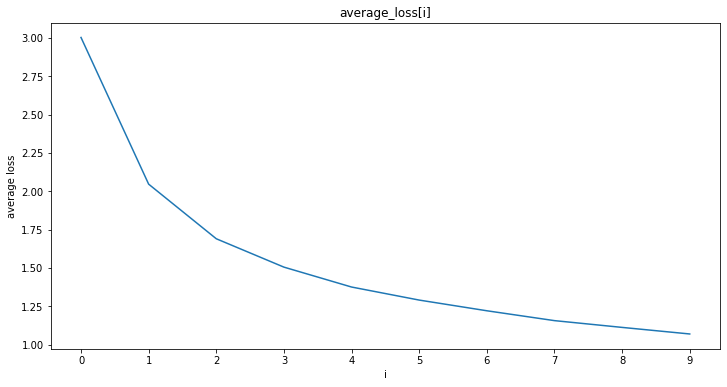

batch size :  128  learning rate :  0.01
epoch 1, trainLoss: 3.525, time elapsed: 10.296131 seconds
epoch 2, trainLoss: 3.045, time elapsed: 10.338798 seconds
epoch 3, trainLoss: 2.700, time elapsed: 10.322966 seconds
epoch 4, trainLoss: 2.396, time elapsed: 10.335179 seconds
epoch 5, trainLoss: 2.170, time elapsed: 10.325711 seconds
epoch 6, trainLoss: 1.979, time elapsed: 10.306832 seconds
epoch 7, trainLoss: 1.855, time elapsed: 10.260154 seconds
epoch 8, trainLoss: 1.752, time elapsed: 10.290613 seconds
epoch 9, trainLoss: 1.681, time elapsed: 10.32138 seconds
epoch 10, trainLoss: 1.597, time elapsed: 10.327518 seconds
total training time: 1.719 minutes
          _  Train   Test
0  Accuracy  45.44  45.63


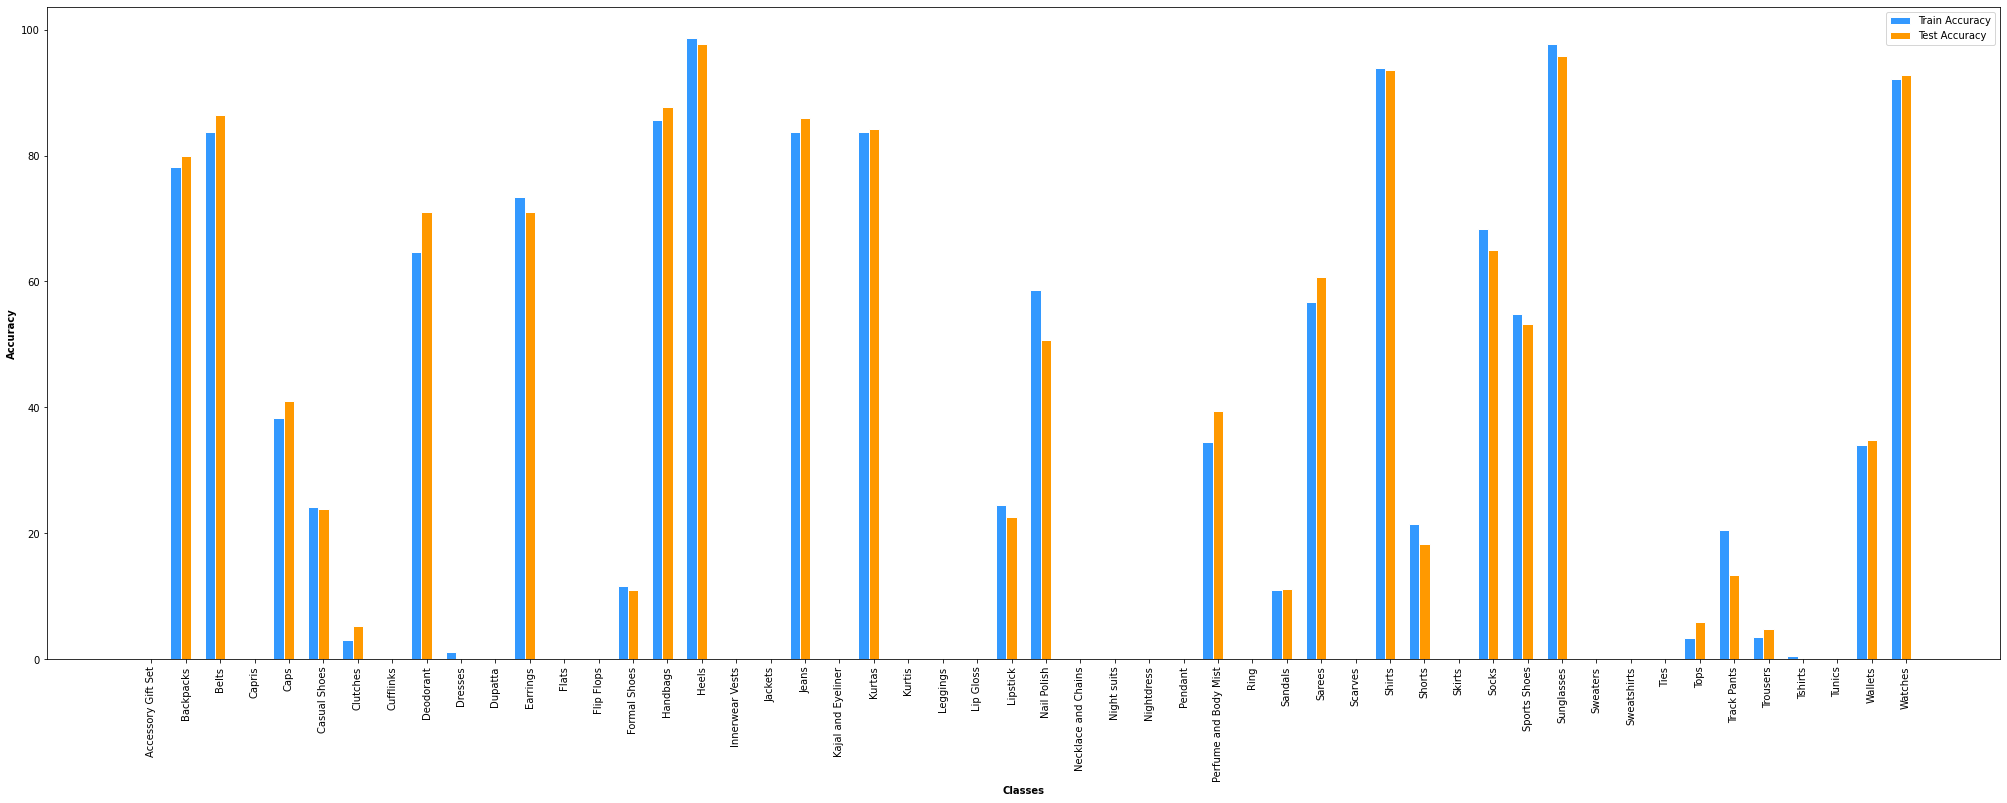

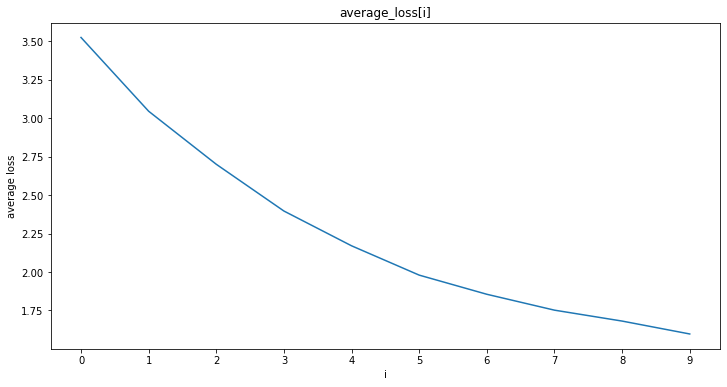

In [ ]:
checkDifferentBatchSizes([32, 128], [optLr])

---
##7B:

**How Should we change learning rate as the batch size increases?**

It's logical that when batch size increases (multiplies by **k**), <u>we keep learning rate untouched </u> (because model gets less noisy by increasing batch size by default) <u>or increase learning rate with a coefficient or other ways related to k (kN, sqrt(k) or ...)</u> in order for increasing the role of bigger batch sizes in comparison to smaller ones.

batch size :  128  learning rate :  0.005
epoch 1, trainLoss: 3.658, time elapsed: 10.346757 seconds
epoch 2, trainLoss: 3.410, time elapsed: 10.350642 seconds
epoch 3, trainLoss: 3.249, time elapsed: 10.332904 seconds
epoch 4, trainLoss: 2.938, time elapsed: 10.331302 seconds
epoch 5, trainLoss: 2.714, time elapsed: 10.314227 seconds
epoch 6, trainLoss: 2.543, time elapsed: 10.35712 seconds
epoch 7, trainLoss: 2.375, time elapsed: 10.341665 seconds
epoch 8, trainLoss: 2.268, time elapsed: 10.294763 seconds
epoch 9, trainLoss: 2.130, time elapsed: 10.322745 seconds
epoch 10, trainLoss: 2.058, time elapsed: 10.630709 seconds
total training time: 1.727 minutes
          _  Train   Test
0  Accuracy  27.66  27.40


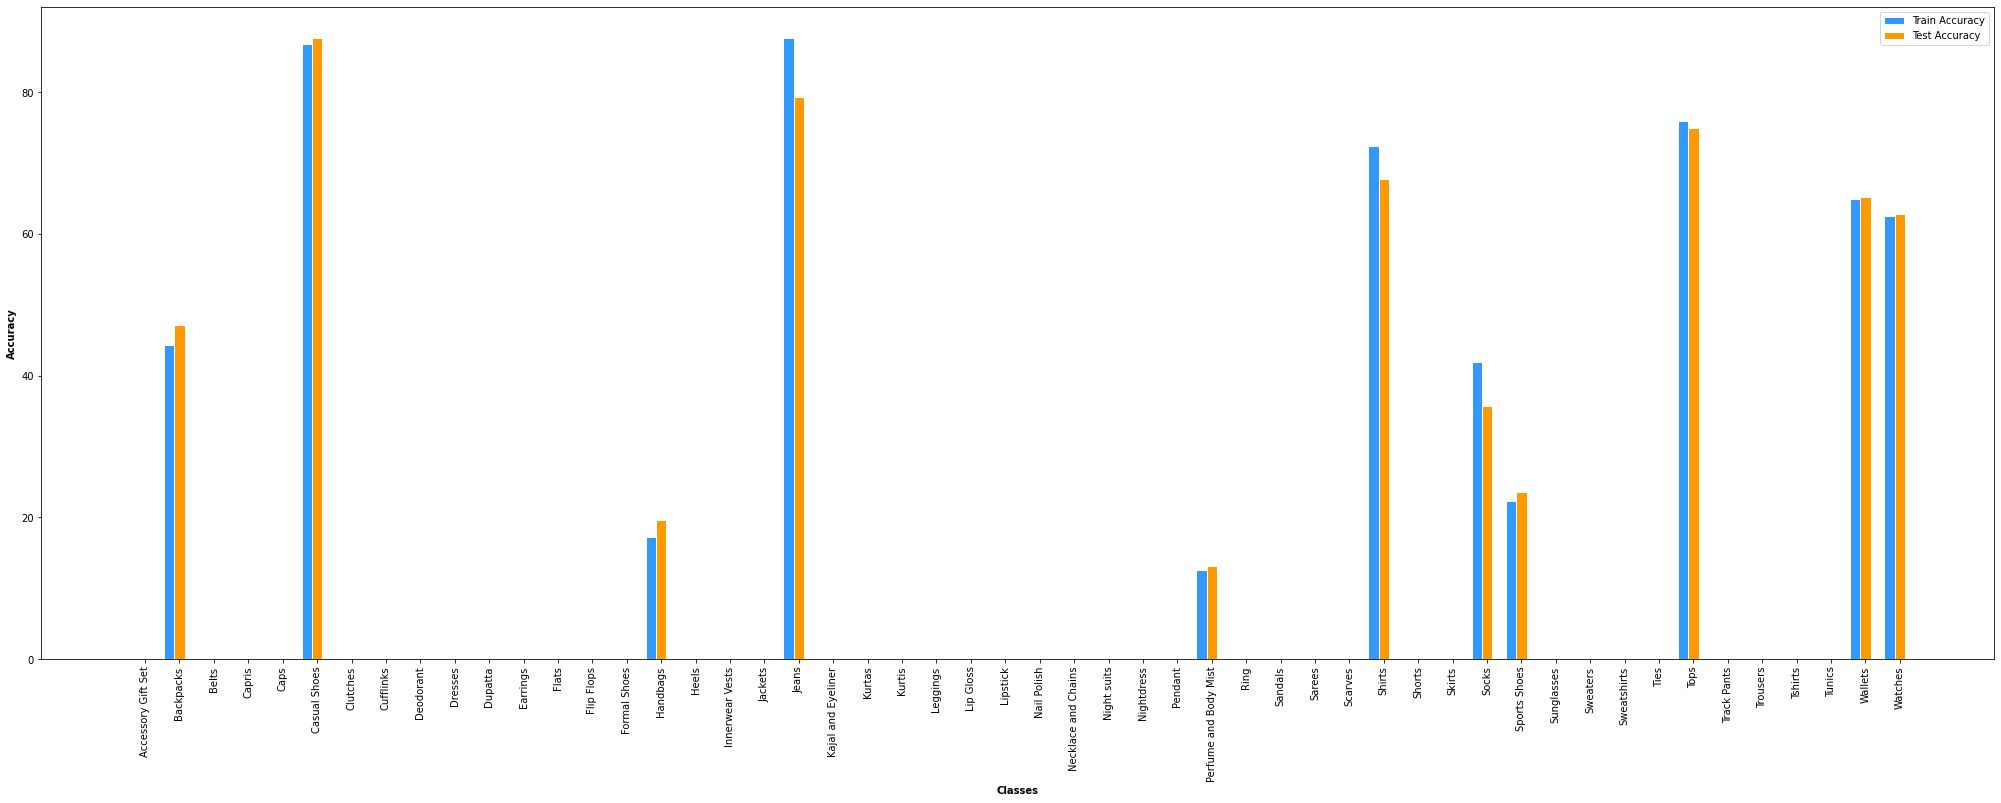

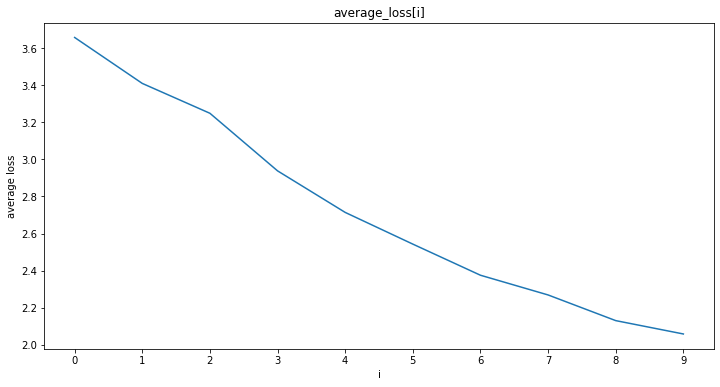

batch size :  128  learning rate :  0.02
epoch 1, trainLoss: 3.347, time elapsed: 10.33399 seconds
epoch 2, trainLoss: 2.689, time elapsed: 10.345769 seconds
epoch 3, trainLoss: 2.226, time elapsed: 10.343278 seconds
epoch 4, trainLoss: 1.987, time elapsed: 10.359873 seconds
epoch 5, trainLoss: 1.811, time elapsed: 10.319447 seconds
epoch 6, trainLoss: 1.664, time elapsed: 10.306605 seconds
epoch 7, trainLoss: 1.609, time elapsed: 10.302928 seconds
epoch 8, trainLoss: 1.488, time elapsed: 10.299587 seconds
epoch 9, trainLoss: 1.425, time elapsed: 10.274625 seconds
epoch 10, trainLoss: 1.364, time elapsed: 10.315389 seconds
total training time: 1.720 minutes
          _  Train   Test
0  Accuracy  31.30  30.66


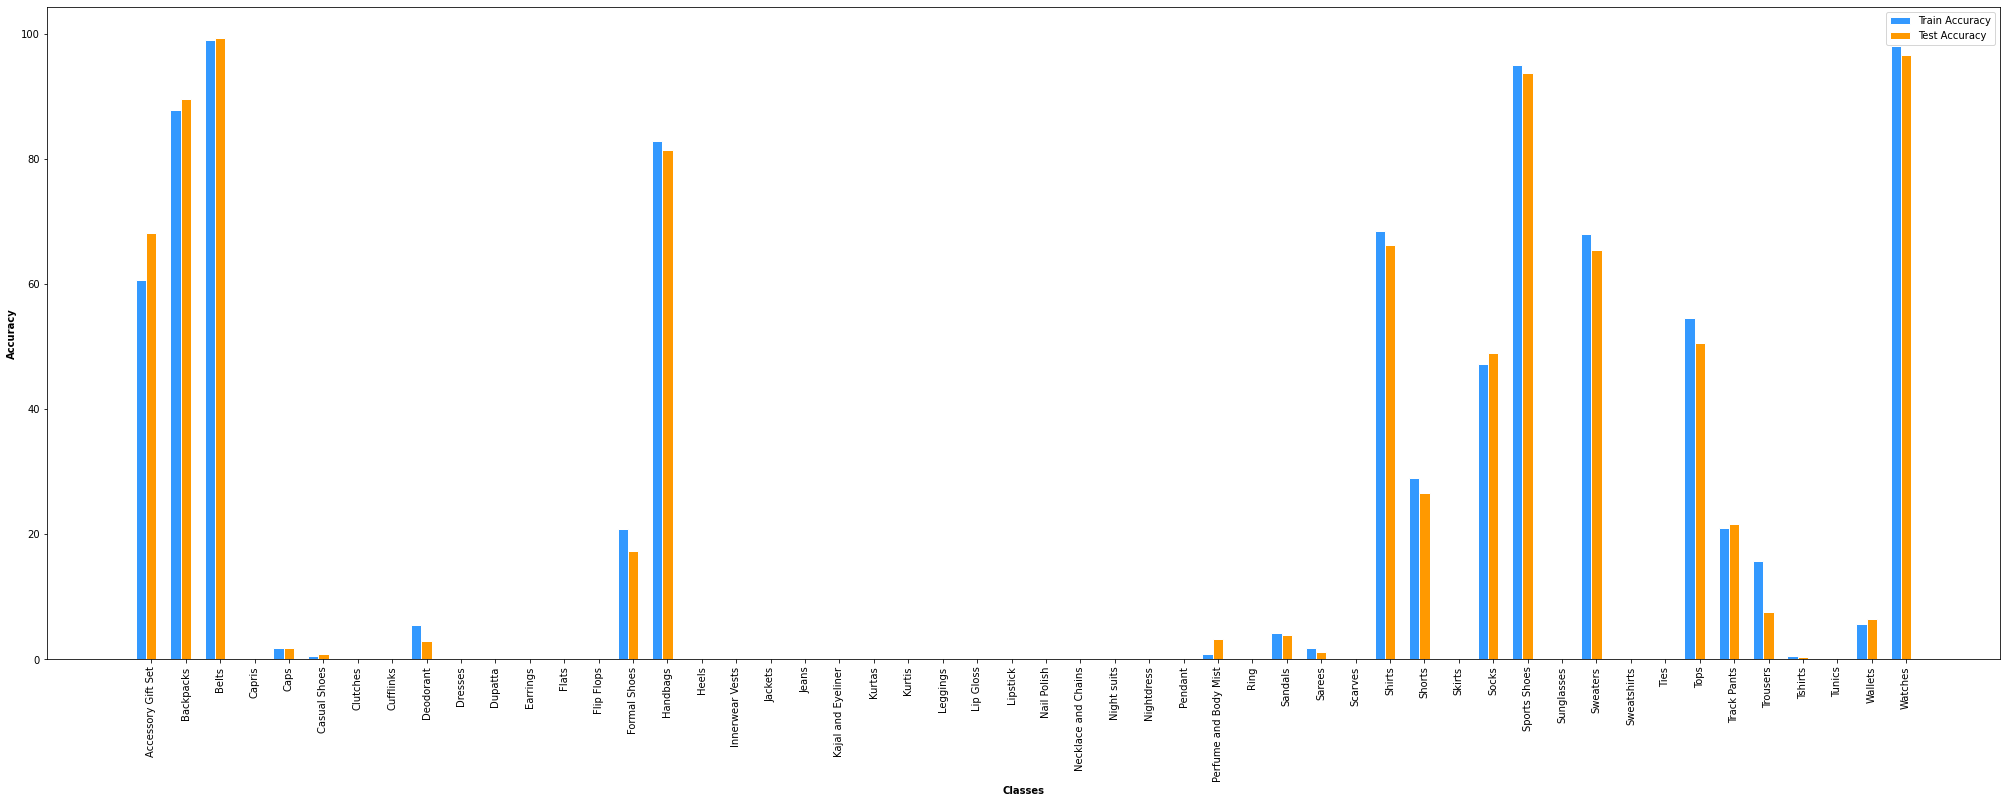

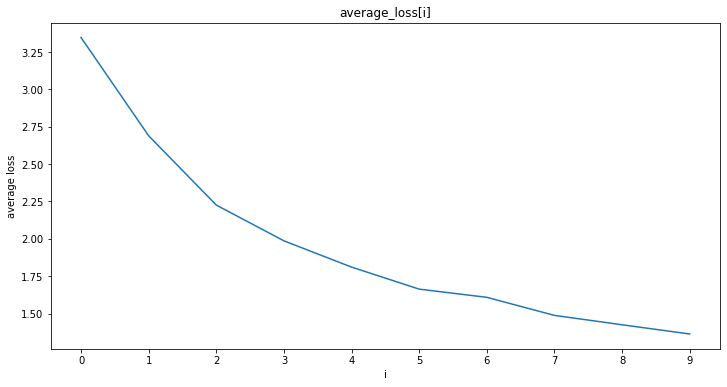

In [ ]:
checkDifferentBatchSizes([128], [optLr * 0.5, optLr * 2])

---
# Part 8

##8A:

Momentum which is combined with SGD(stochastic gradient decent), can help to accelerate convergence by introducing an extra term **γ** of the update vector of the past time step to the current update vector:

vt=**γ**v(t−1)+η∇θJ(θ)

θ=θ−vt

**Cons of not using momentum:**

The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation. (zigzag movements reduce -> smooth updates). 

so without using momentum we won't get these points and get slower convergence than SGD with momentum.

**pros of not using momentum:**

If the momentum is not choosen wisely (for instance very high values), we will most likely miss the local minima, rolling past it, but then rolling backwards, missing it again. If the momentum is too much. (swinging back and forward between local minima).

---

##8B:

We test our model over three different values of momentum : 
0.5, 0.9, 0.98

and default value for previous parts was 0.

**Results :** (results are shown in diagrams beneath)

momentum -> [train accuracy, test accuracy, final loss, training time(mins)]

0.5 -> [35.47%, 35.42%, 1.061, 2.81]

0.9 -> [61.73%, 60.94%, 0.913, 2.82]

0.98 -> [45.74%, 44.78%, 1.605, 2.82]

**So, accuracies : for 0.9 > for 0.98 > for 0.5**

<mark>Optimum value for Momentum for my model = 0.9</mark>

---

##8C : 

**No.**

If the momentum is too big, we will most likely miss the local minima, rolling past it, but then rolling backwards, missing it again. So, we could just swing back and forward between the local minima If the momentum is too much.

In [ ]:
def checkDifferentMomentums(momentums) : 
  
  for mm in momentums : 
    print("momentum : ", mm)
    [activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, optLr, 64, 10, 16, mm)
    avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
    showPartDetails(model, trainLoader, testLoader, avgLosses)

momentum :  0.5
epoch 1, trainLoss: 3.006, time elapsed: 16.93864 seconds
epoch 2, trainLoss: 2.033, time elapsed: 16.928063 seconds
epoch 3, trainLoss: 1.644, time elapsed: 16.88302 seconds
epoch 4, trainLoss: 1.460, time elapsed: 16.938697 seconds
epoch 5, trainLoss: 1.341, time elapsed: 16.901176 seconds
epoch 6, trainLoss: 1.266, time elapsed: 16.930173 seconds
epoch 7, trainLoss: 1.195, time elapsed: 16.980141 seconds
epoch 8, trainLoss: 1.150, time elapsed: 16.92696 seconds
epoch 9, trainLoss: 1.101, time elapsed: 16.912107 seconds
epoch 10, trainLoss: 1.061, time elapsed: 16.905949 seconds
total training time: 2.821 minutes
          _  Train   Test
0  Accuracy  35.47  35.42


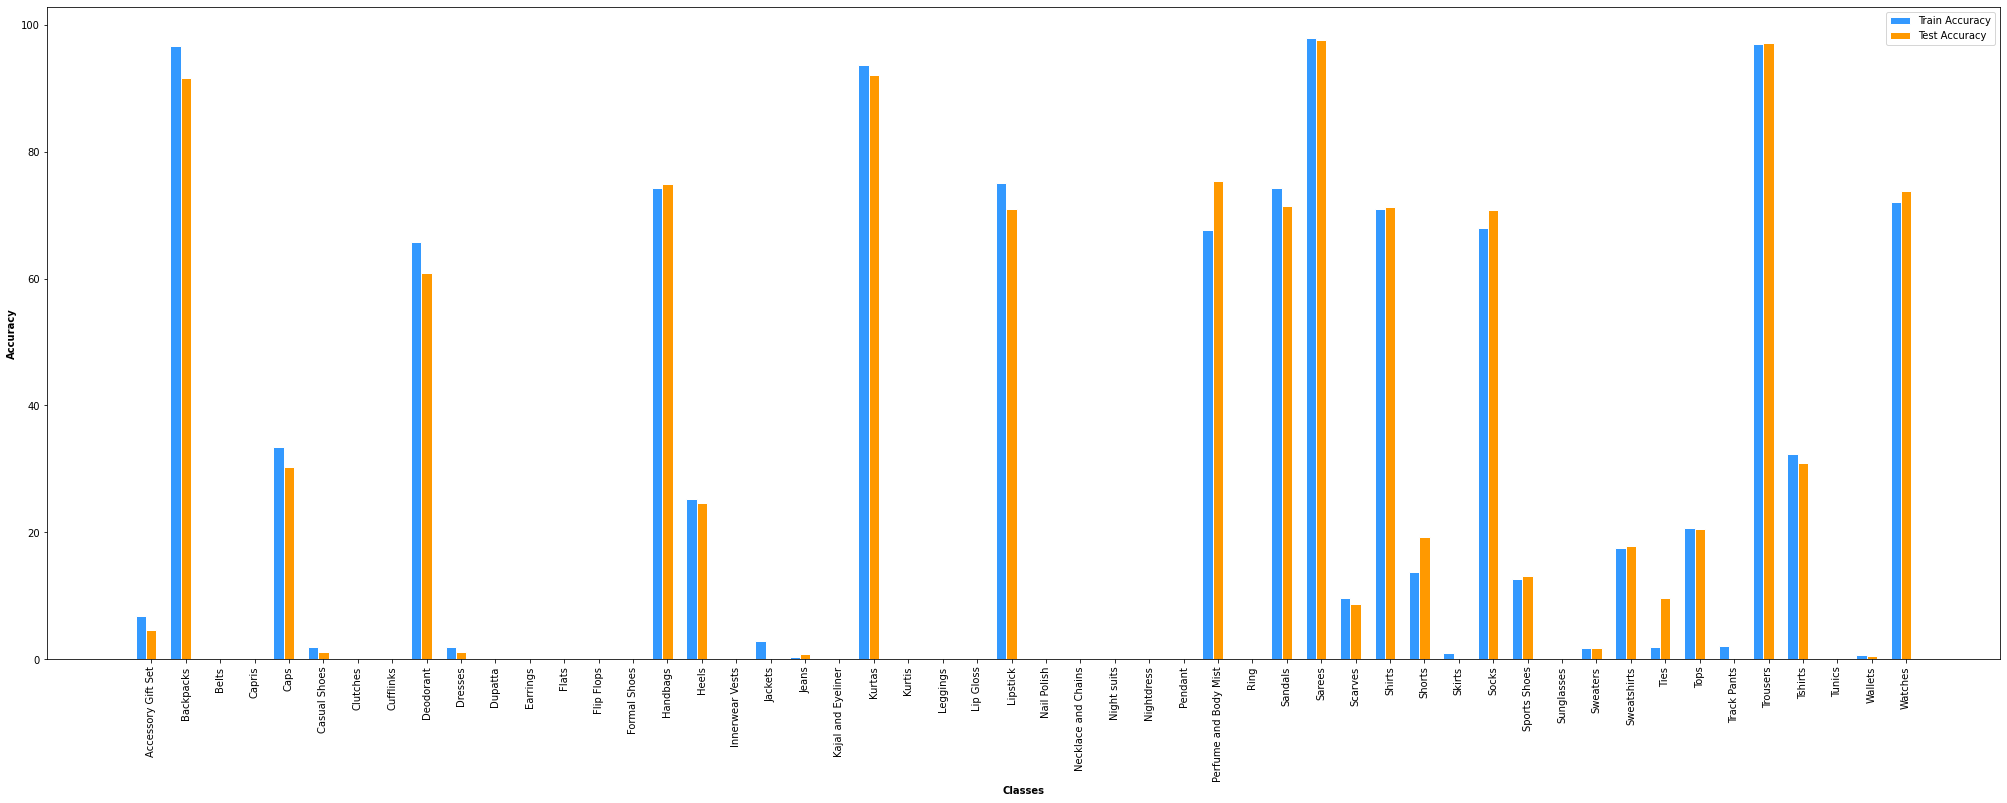

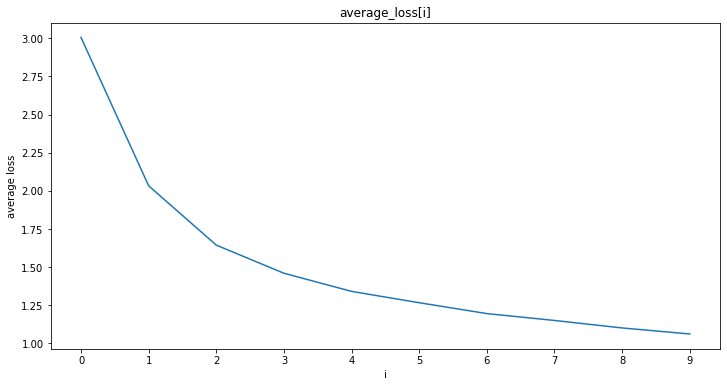

momentum :  0.9
epoch 1, trainLoss: 2.397, time elapsed: 16.967153 seconds
epoch 2, trainLoss: 1.550, time elapsed: 16.924218 seconds
epoch 3, trainLoss: 1.342, time elapsed: 16.974946 seconds
epoch 4, trainLoss: 1.195, time elapsed: 16.973687 seconds
epoch 5, trainLoss: 1.148, time elapsed: 16.913927 seconds
epoch 6, trainLoss: 1.058, time elapsed: 16.926899 seconds
epoch 7, trainLoss: 1.011, time elapsed: 16.938711 seconds
epoch 8, trainLoss: 0.968, time elapsed: 16.947158 seconds
epoch 9, trainLoss: 0.930, time elapsed: 16.957424 seconds
epoch 10, trainLoss: 0.913, time elapsed: 16.892805 seconds
total training time: 2.824 minutes
          _  Train   Test
0  Accuracy  61.73  60.94


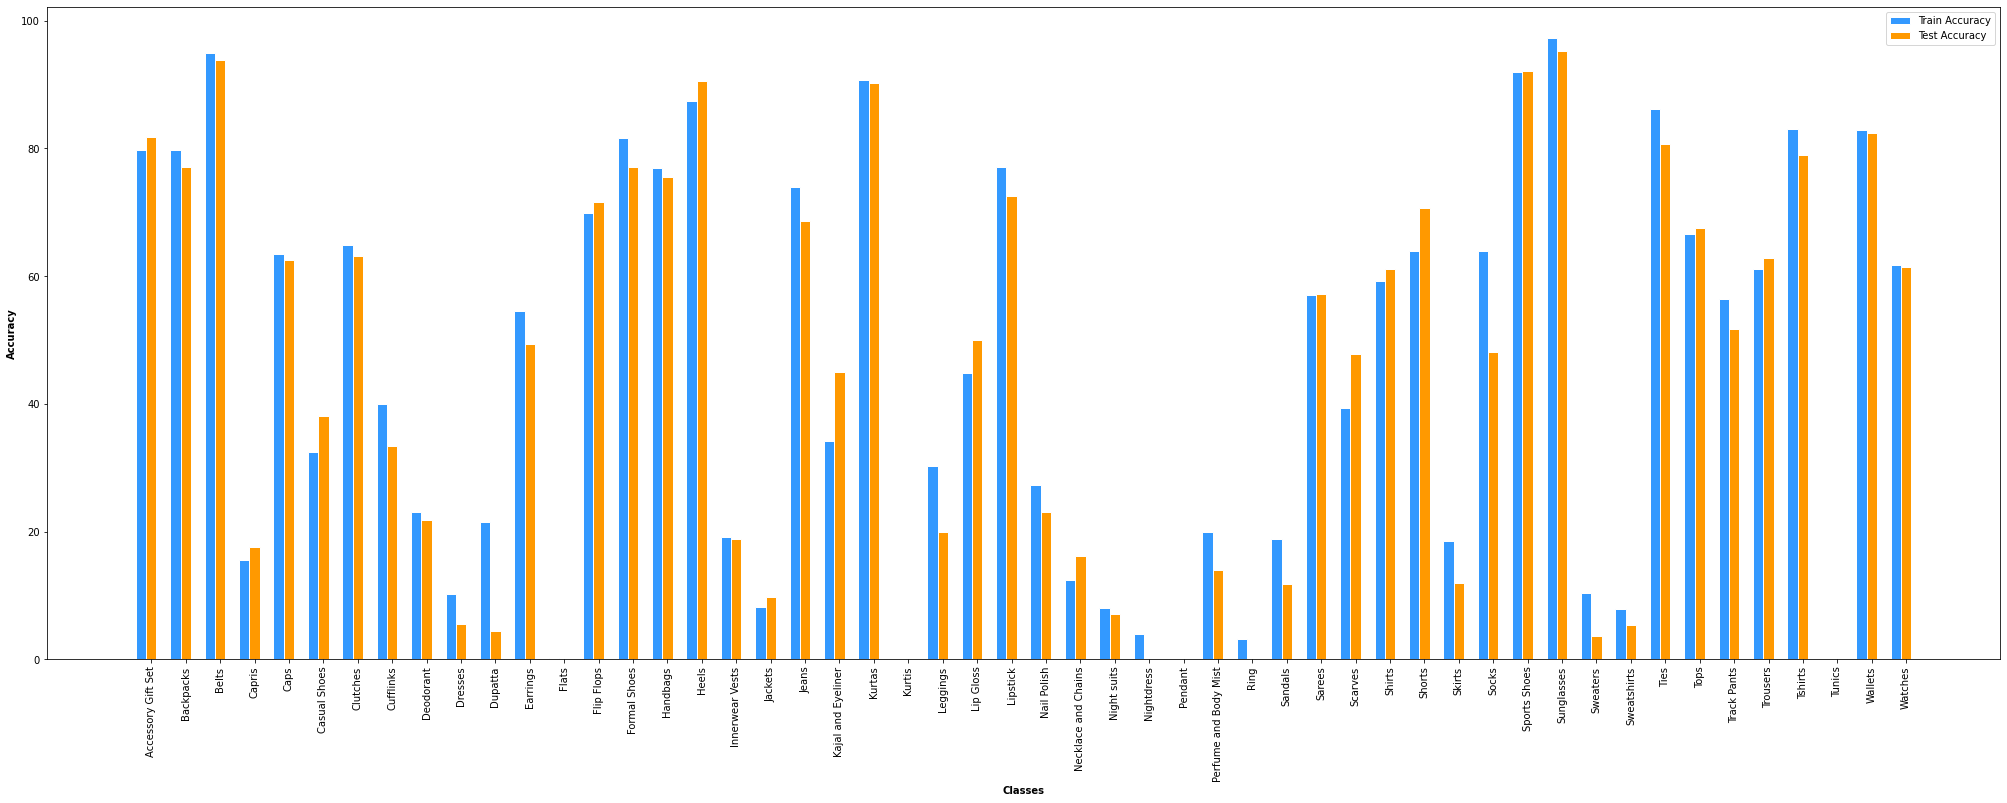

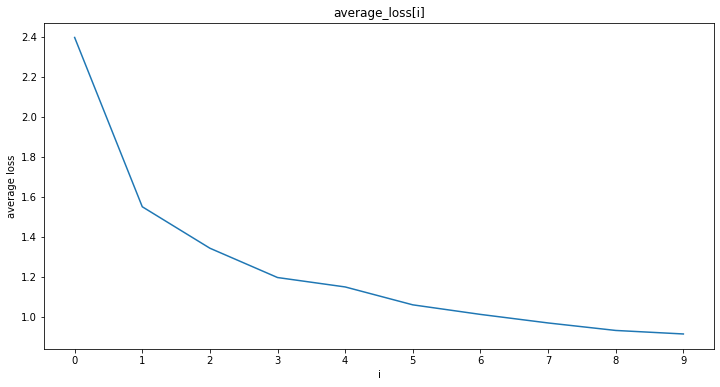

momentum :  0.98
epoch 1, trainLoss: 2.512, time elapsed: 16.922025 seconds
epoch 2, trainLoss: 2.052, time elapsed: 16.896192 seconds
epoch 3, trainLoss: 2.041, time elapsed: 16.918985 seconds
epoch 4, trainLoss: 1.898, time elapsed: 16.910033 seconds
epoch 5, trainLoss: 1.837, time elapsed: 16.948979 seconds
epoch 6, trainLoss: 1.719, time elapsed: 16.932267 seconds
epoch 7, trainLoss: 1.844, time elapsed: 16.916264 seconds
epoch 8, trainLoss: 1.732, time elapsed: 16.881929 seconds
epoch 9, trainLoss: 1.732, time elapsed: 17.055234 seconds
epoch 10, trainLoss: 1.605, time elapsed: 16.950666 seconds
total training time: 2.822 minutes
          _  Train   Test
0  Accuracy  45.74  44.78


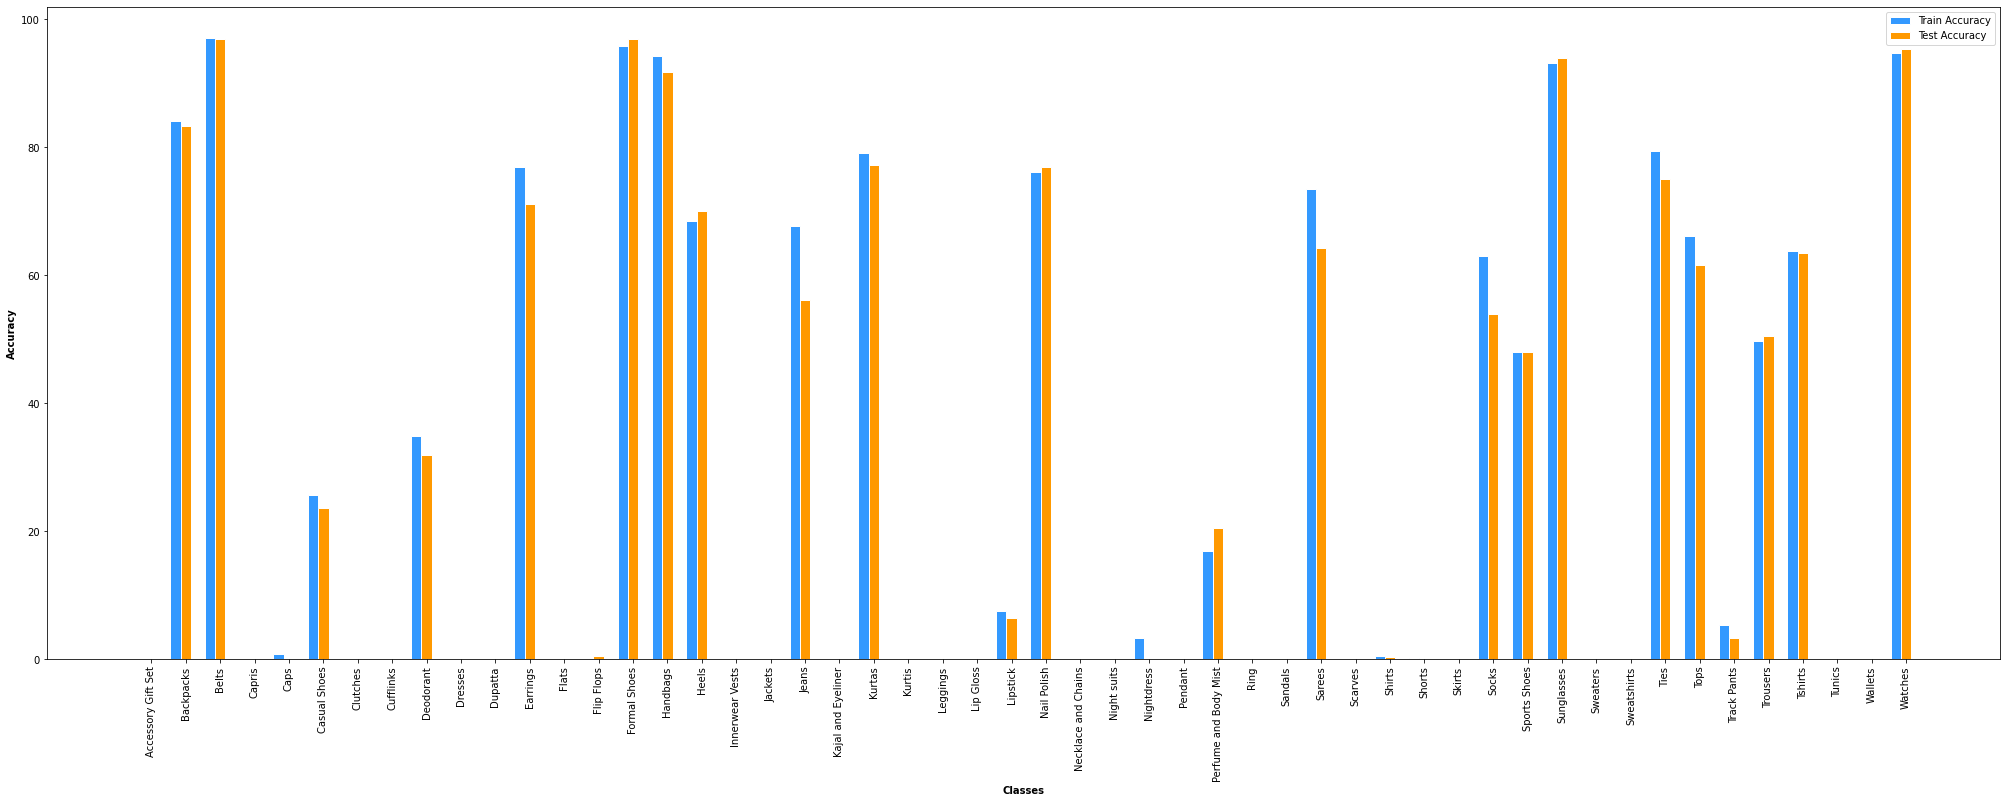

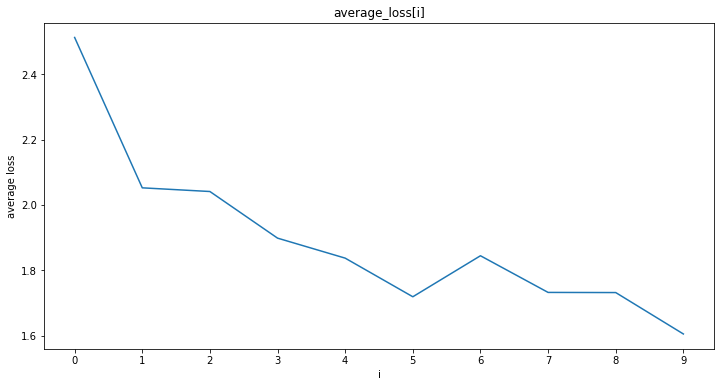

In [ ]:
checkDifferentMomentums([0.5, 0.9, 0.98])

In [ ]:
optMm = 0.9

---
# Part 9

##9A:
With 20 epoches, accuracy increases and average loss final value is less.

**epochs -> (train accuracy, test accuracy, final avg loss)**

**10** -> (61.73%, 60.94%, 0.913)

**20** -> (75.85%, 73.37%, 0.727)

And it's resonable because we repeated training more times, so weigths get closer to true values, and training time for 20 epochs is nearly twice of 10 epochs.

---
##9B:
**Why do we need multiple epochs?**

SGD is an iterative algorithm i.e. it learns gradually and improves in tiny steps, and one epoch means that the optimizer has used every training example once. So, we will need multiple epochs to check every item in dataset multiple times to gain better weights and accuracies.

---

##9C:

**No.**

It can lead to overfitting. If epochs are too many, model will learn a biased weights (improved weights only for train data). So overfitting is possible then. 

---

epoch 1, trainLoss: 2.356, time elapsed: 16.944541 seconds
epoch 2, trainLoss: 1.548, time elapsed: 16.988316 seconds
epoch 3, trainLoss: 1.330, time elapsed: 16.951898 seconds
epoch 4, trainLoss: 1.229, time elapsed: 16.952873 seconds
epoch 5, trainLoss: 1.146, time elapsed: 16.928271 seconds
epoch 6, trainLoss: 1.129, time elapsed: 17.053634 seconds
epoch 7, trainLoss: 1.031, time elapsed: 16.939312 seconds
epoch 8, trainLoss: 0.997, time elapsed: 16.936083 seconds
epoch 9, trainLoss: 0.950, time elapsed: 16.941263 seconds
epoch 10, trainLoss: 0.934, time elapsed: 16.955139 seconds
epoch 11, trainLoss: 0.887, time elapsed: 16.959089 seconds
epoch 12, trainLoss: 0.875, time elapsed: 16.936591 seconds
epoch 13, trainLoss: 0.848, time elapsed: 16.966551 seconds
epoch 14, trainLoss: 0.830, time elapsed: 16.949724 seconds
epoch 15, trainLoss: 0.815, time elapsed: 16.934762 seconds
epoch 16, trainLoss: 0.778, time elapsed: 16.945958 seconds
epoch 17, trainLoss: 0.760, time elapsed: 16.9142

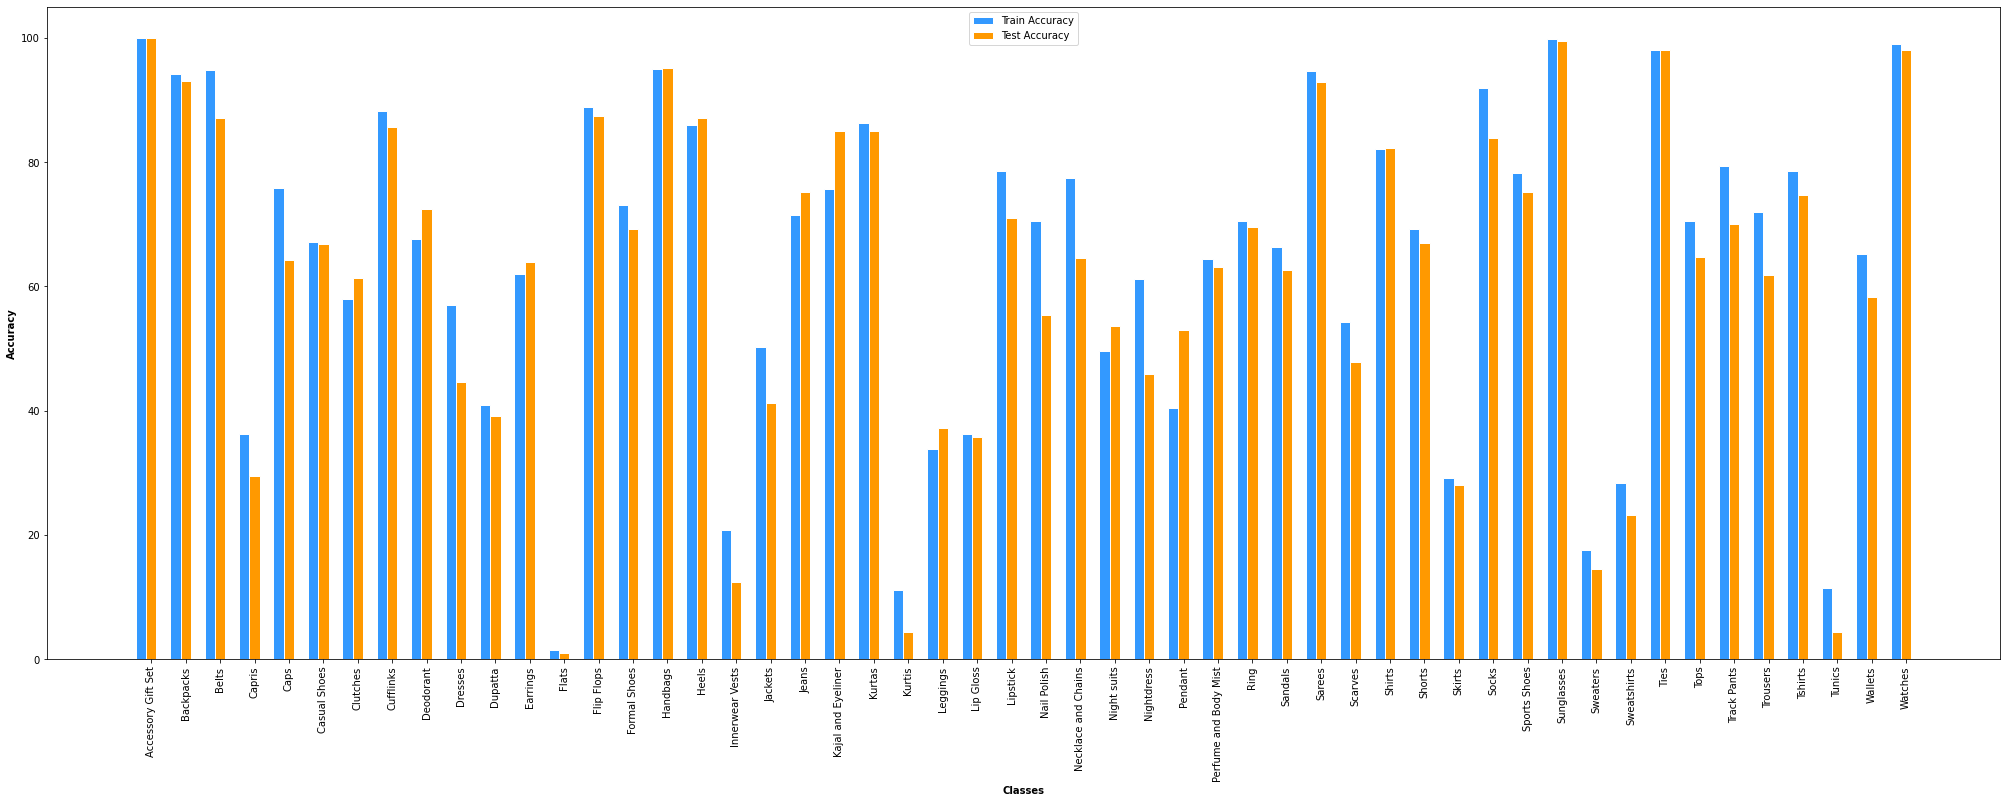

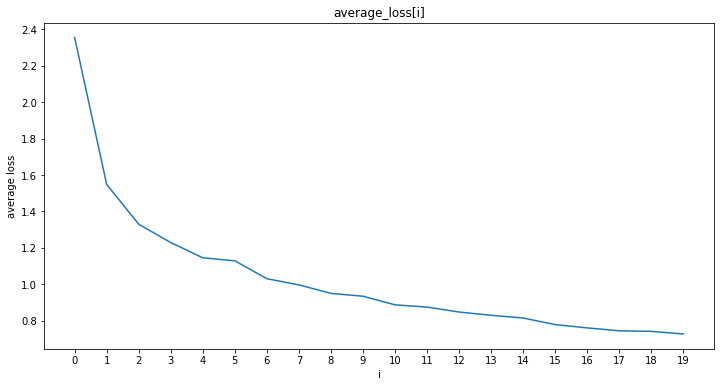

In [ ]:
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, optLr, 64, 20, 16, optMm)
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
showPartDetails(model, trainLoader, testLoader, avgLosses)

---
# Part 10

We know:

**relu**: f(x) =  max(0,x)

**leaky_rely:** f(x) = {if (x>=0) -> x, else -> ax (a ~ 0.01)}

**tanh:** f(x) = (e^x - e^-x) / (e^x + e^-x)

And we used these three functions as activation functions and results were:

---

**Results (shown in beneath diagrams) :**

activation function -> (train accuracy, test accuracy, final avg loss, training time)

**relu** -> (61.73%, 60.94%, 0.913, 2.82)

**leaky_relu** -> (68.84%, 67.84%, 0.916, 2.82)

**tanh** -> (75.22%, 72.44%, 0.788, 2.82)

<u>So in our model tanh works better than leaky_relu, and leaky_relu works better than relu.</u>

Little Advantage of leaky_relu in comparison to relu may be non-zero output for x<0 which makes approximation works more accurate.

And In my opinion tanh is more smoother both in f(x) and f'(x) and  is more symmetric for positive and negative values, so it works the best in our model. (but it might not be always true and in many cases relu works better than tanh).



In [ ]:
def checkDifferentActFuncs() :  
    
    print("activation function : ", "tanh")
    [activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.tanh, optLr, 64, 10, 16, optMm)
    avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
    showPartDetails(model, trainLoader, testLoader, avgLosses)

    print("activation function : ", "leaky_relu")
    [activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.leaky_relu, optLr, 64, 10, 16, optMm)
    avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
    showPartDetails(model, trainLoader, testLoader, avgLosses)

activation function :  tanh


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, trainLoss: 1.984, time elapsed: 17.062548 seconds
epoch 2, trainLoss: 1.273, time elapsed: 16.943162 seconds
epoch 3, trainLoss: 1.153, time elapsed: 16.947033 seconds
epoch 4, trainLoss: 1.062, time elapsed: 16.940462 seconds
epoch 5, trainLoss: 0.981, time elapsed: 16.991091 seconds
epoch 6, trainLoss: 0.946, time elapsed: 16.917492 seconds
epoch 7, trainLoss: 0.886, time elapsed: 16.983946 seconds
epoch 8, trainLoss: 0.867, time elapsed: 17.08475 seconds
epoch 9, trainLoss: 0.837, time elapsed: 16.910273 seconds
epoch 10, trainLoss: 0.788, time elapsed: 16.898322 seconds
total training time: 2.828 minutes
          _  Train   Test
0  Accuracy  75.22  72.44


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


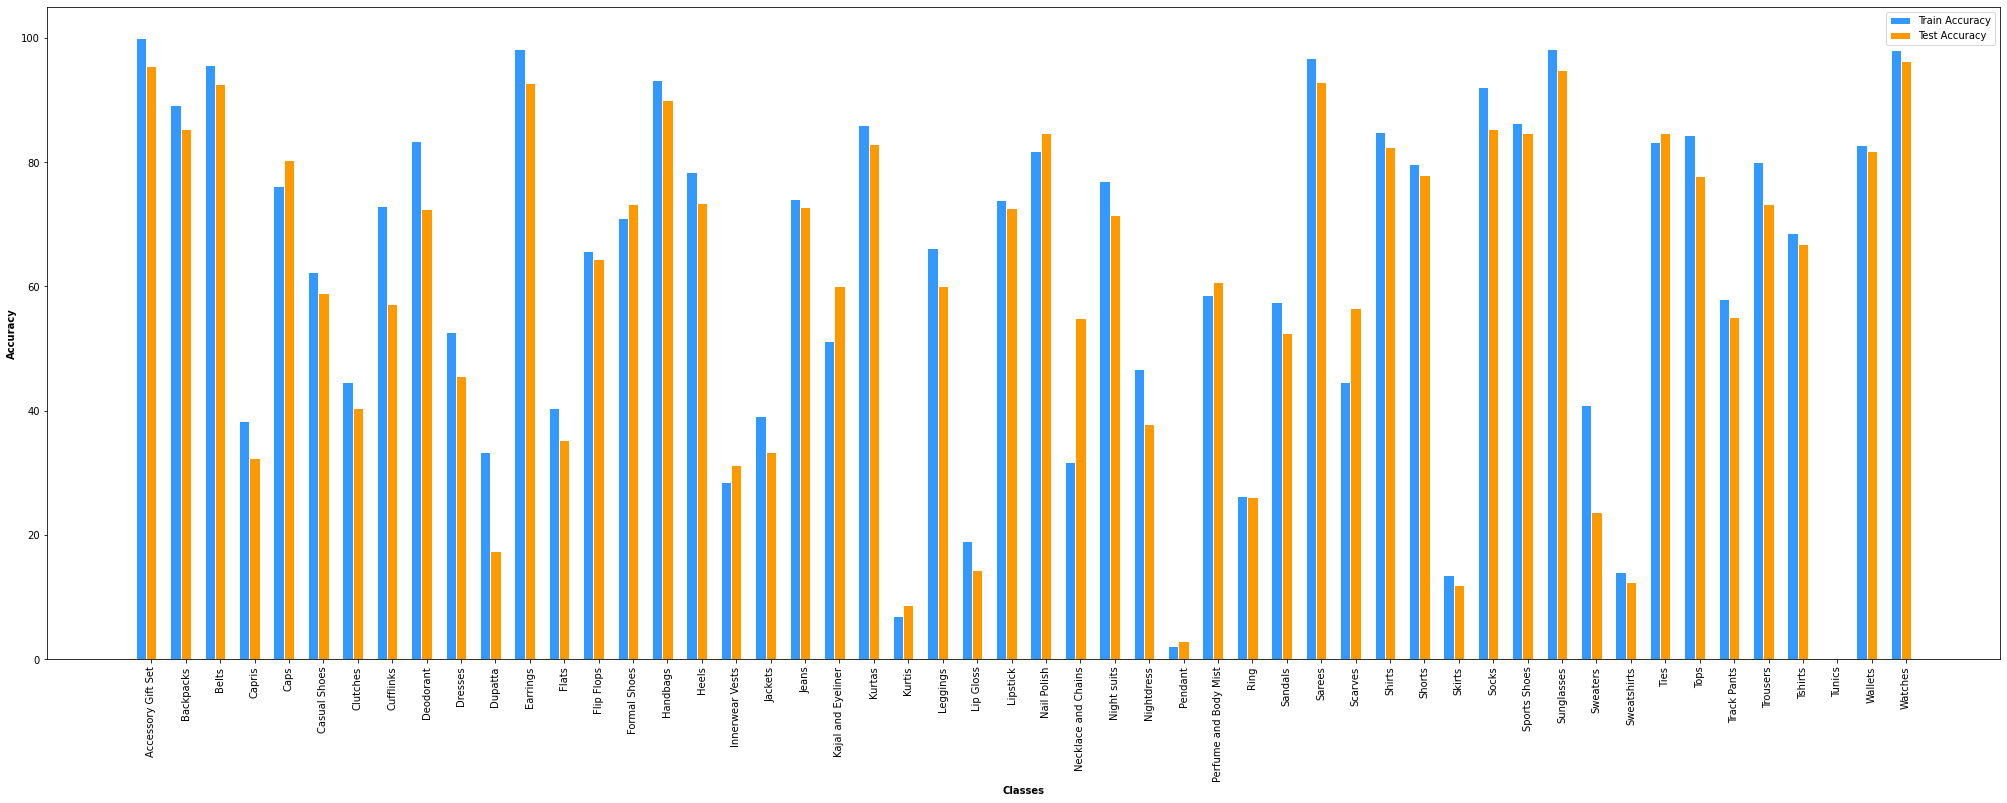

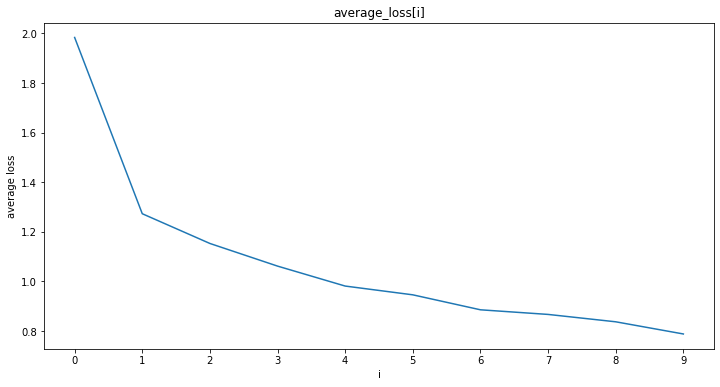

activation function :  leaky_relu
epoch 1, trainLoss: 2.352, time elapsed: 16.91775 seconds
epoch 2, trainLoss: 1.525, time elapsed: 16.921674 seconds
epoch 3, trainLoss: 1.326, time elapsed: 16.95007 seconds
epoch 4, trainLoss: 1.221, time elapsed: 16.920373 seconds
epoch 5, trainLoss: 1.137, time elapsed: 16.917092 seconds
epoch 6, trainLoss: 1.082, time elapsed: 16.950593 seconds
epoch 7, trainLoss: 1.035, time elapsed: 17.045149 seconds
epoch 8, trainLoss: 0.977, time elapsed: 16.892395 seconds
epoch 9, trainLoss: 0.926, time elapsed: 16.9485 seconds
epoch 10, trainLoss: 0.916, time elapsed: 16.927127 seconds
total training time: 2.823 minutes
          _  Train   Test
0  Accuracy  68.84  67.84


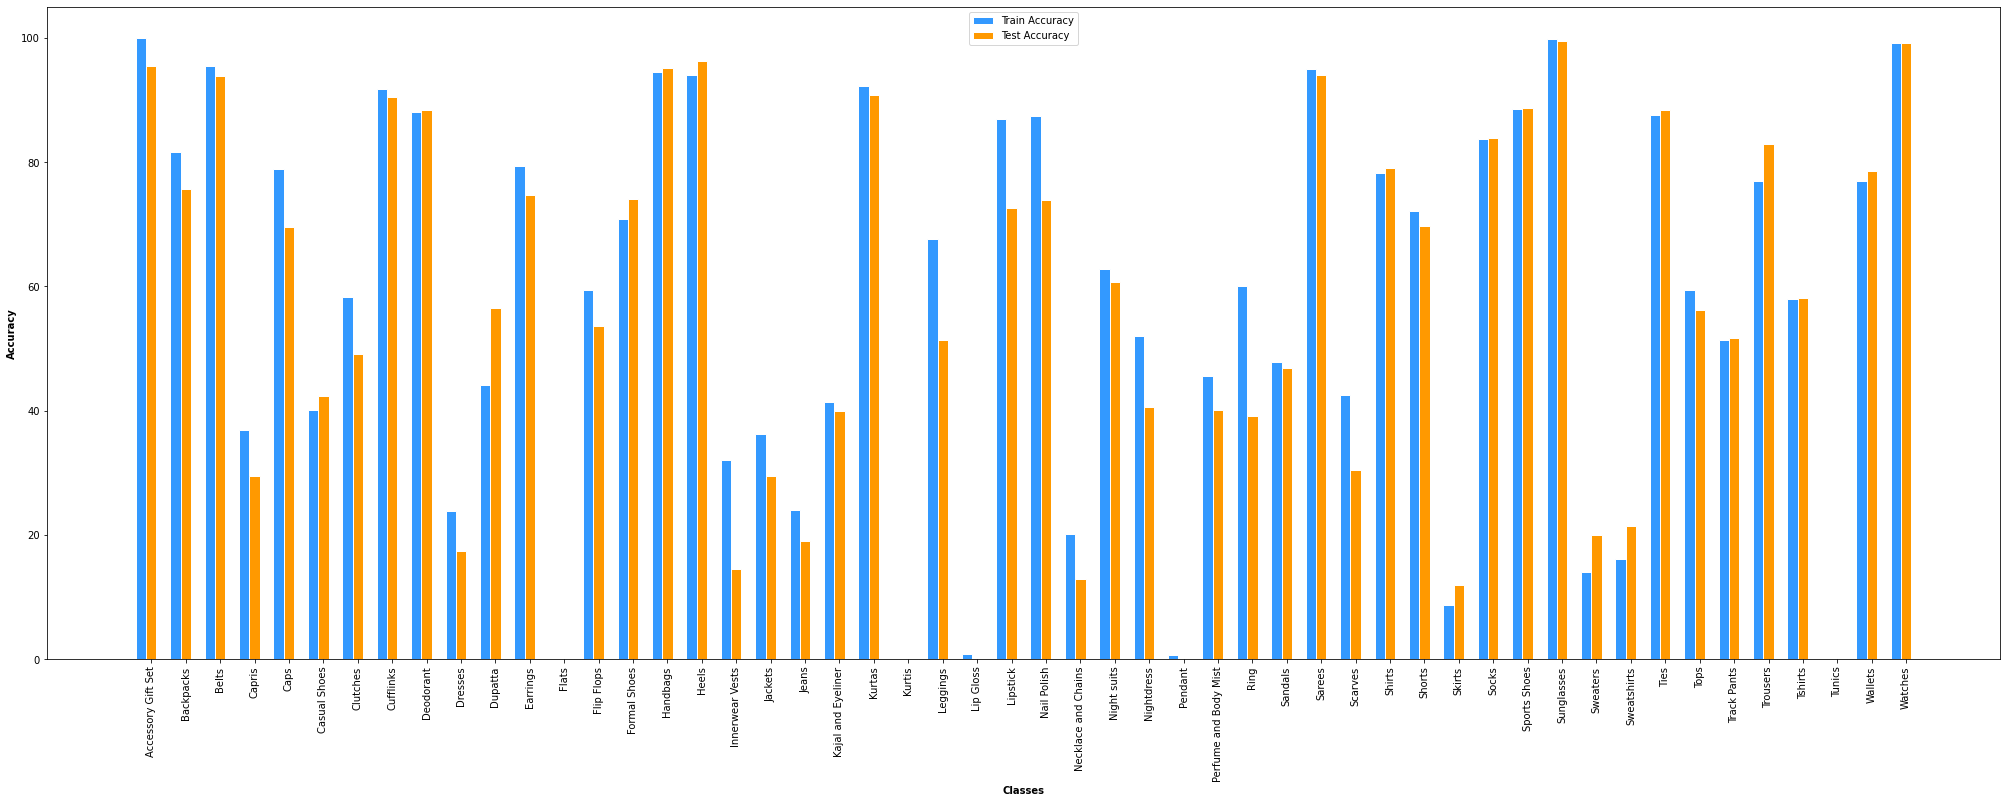

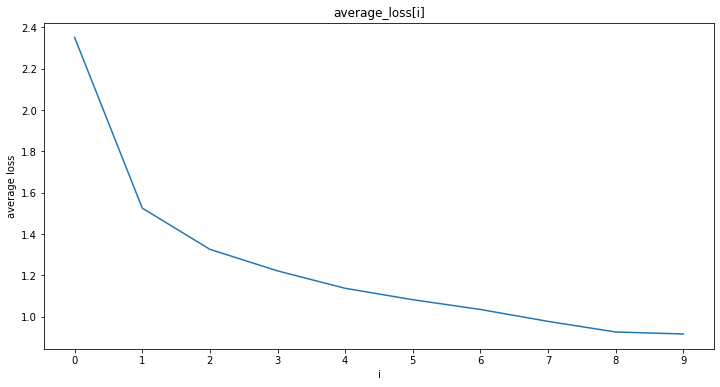

In [ ]:
checkDifferentActFuncs()

---
# Part 11

## 11A : 
In general, regularization is a technique to that helps reduce overfitting or reduce variance in our network. And it works by adding an additional value to loss function (<mark>loss + x</mark> **where x is the reguralization factor**).

We have lots of regularization techniques for example L1 and L2 regularization and ... . 
If by some hyper parameter tunings (which are inside **x** <u>such as lambda inside L2</u>) we make x a large number, then loss + x would be large too. So, in order to reduce loss, we must reduce weights (close to zero but not exact-zero) and this would make the impact of those weights and layers less and in worse case would almost drop some layers impacts. so it's crutial to choose regularization parameter wisely to gain acceptable results. And these lowering weights can prevent overfitting and variances.

![L1 and L2 regularization img](https://miro.medium.com/max/1000/1*-LydhQEDyg-4yy5hGEj5wA.png)

---

##11B:
The *weight_decay* parameter adds a L2 penalty (**E = plain error + weight penalty**) to the cost which can effectively lead to smaller model weights as explained in 11A.

---

##11C:

With weight_Decay = 0.1 : (results are shown in beneath diagrams)

accuracy ~ 9%

final avg loss  ~ 3.328

and runtime delay increases in comparison to default (part8: weight_decay = 0)

---




epoch 1, trainLoss: 3.460, time elapsed: 19.087606 seconds
epoch 2, trainLoss: 3.353, time elapsed: 19.100461 seconds
epoch 3, trainLoss: 3.339, time elapsed: 19.119441 seconds
epoch 4, trainLoss: 3.322, time elapsed: 19.156991 seconds
epoch 5, trainLoss: 3.322, time elapsed: 19.149486 seconds
epoch 6, trainLoss: 3.335, time elapsed: 19.042088 seconds
epoch 7, trainLoss: 3.320, time elapsed: 19.083886 seconds
epoch 8, trainLoss: 3.343, time elapsed: 19.095121 seconds
epoch 9, trainLoss: 3.323, time elapsed: 19.231762 seconds
epoch 10, trainLoss: 3.328, time elapsed: 19.068061 seconds
total training time: 3.186 minutes
          _ Train  Test
0  Accuracy  9.90  9.92


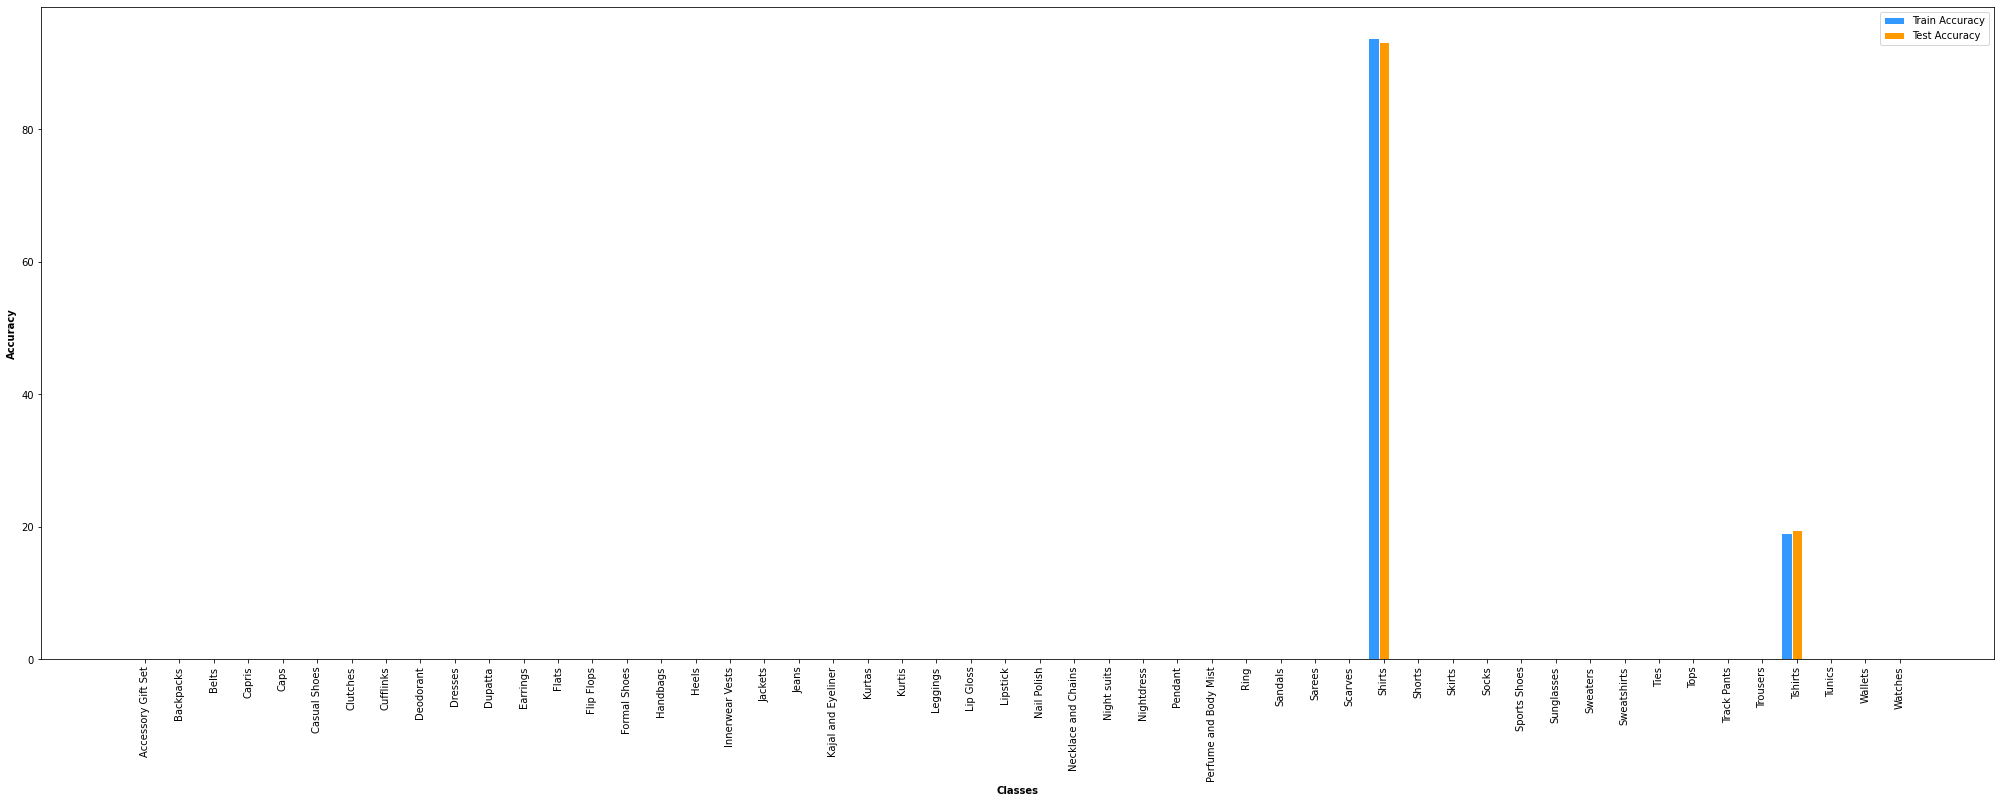

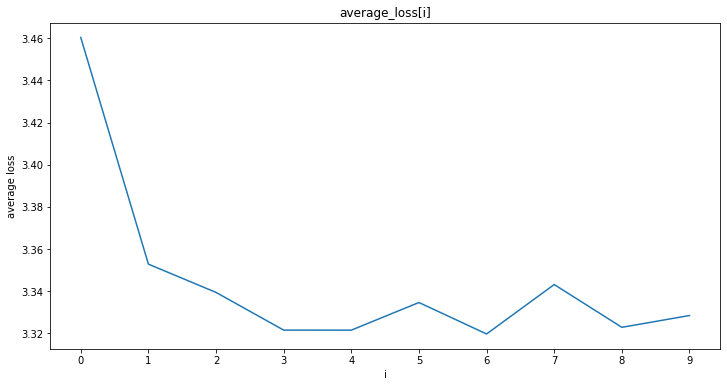

In [ ]:
weight_decay = 0.1
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, optLr, 64, 10, 16, optMm, weight_decay)
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
showPartDetails(model, trainLoader, testLoader, avgLosses)

---
##11D: 
**Results:**

weight_decay -> (~accuracy, final avg loss, runtime(mins))

0 (default:part8) -> (61%, 0.913, 2.824)

0.01 -> (38%, 1.445, 3.188)

0.1 -> (9.9%, 3.328, 3.186)

For big weight decays like 0.1, results have a poor accuracy and loss, it's probably because weight decay is very large that makes weights too small to ba able to learn during trainings.

results for 0.01 is more resonable than 0.1.

Ultimately, we think that maybe because we didn't see any overfitting or variance during trainigs, adding weight_decay was unneccesary ane weight_Decay = 0 works the best.

---

epoch 1, trainLoss: 2.452, time elapsed: 19.154797 seconds
epoch 2, trainLoss: 1.746, time elapsed: 19.222116 seconds
epoch 3, trainLoss: 1.597, time elapsed: 19.083785 seconds
epoch 4, trainLoss: 1.578, time elapsed: 19.125544 seconds
epoch 5, trainLoss: 1.526, time elapsed: 19.150073 seconds
epoch 6, trainLoss: 1.511, time elapsed: 19.093541 seconds
epoch 7, trainLoss: 1.506, time elapsed: 19.14676 seconds
epoch 8, trainLoss: 1.507, time elapsed: 19.077596 seconds
epoch 9, trainLoss: 1.461, time elapsed: 19.093022 seconds
epoch 10, trainLoss: 1.445, time elapsed: 19.103036 seconds
total training time: 3.188 minutes
          _  Train   Test
0  Accuracy  38.72  38.81


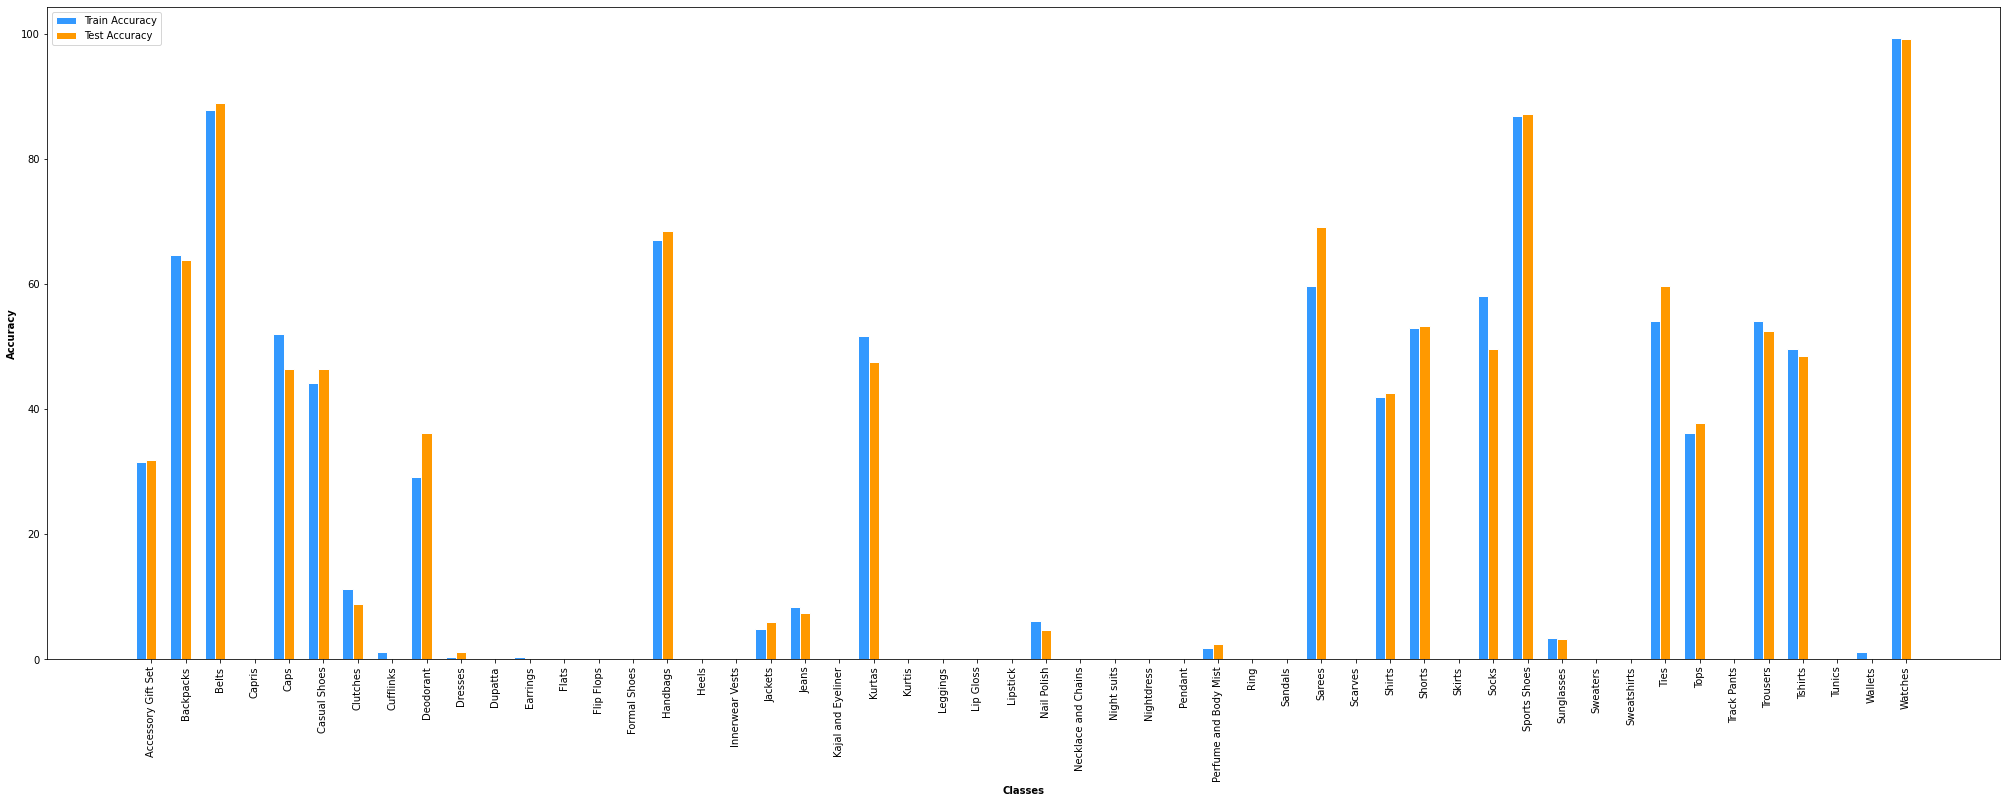

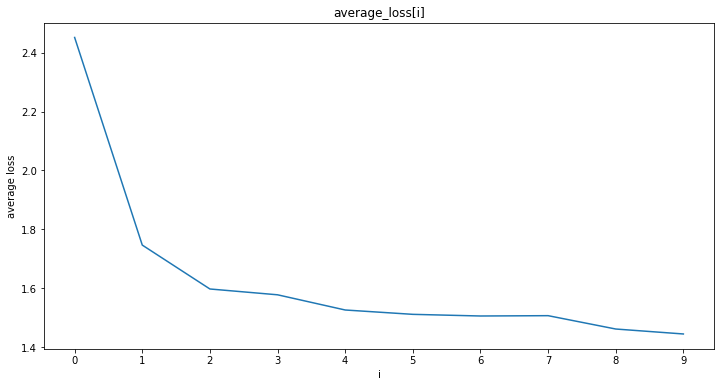

In [ ]:
weight_decay = 0.01
[activationFunction, model, criterion, learningRate, optimizer, batchSize, epochs, trainLoader, testLoader] = makeRequisites(255, datasetClasses, F.relu, optLr, 64, 10, 16, optMm, weight_decay)
avgLosses = fit(model, trainLoader, device, criterion, optimizer, epochs)
showPartDetails(model, trainLoader, testLoader, avgLosses)

#Conclusion

In this project we first implemented a 5-layered model with pytorch and trained it with some default settings. (**NOTE: we didn't implement softmax layer because pytorch itself, does it for us**) then we started to improve performance by dealing with features and parameters (like transformer functions, learning rate, batch size, momentum, activation function, regularization with weight_decay and ...) and saw how they influence our final average loss, accuracy, runtime delay, etc.

So there are lots of ways to improve performace of a nn model or even a deep nn model except for changing layers' structures.